In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries and Dataset (NER DATASET 1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, SimpleRNN, Bidirectional, TimeDistributed, Input, Dropout, SpatialDropout1D, Masking
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import ast
import re
import io
import os
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/Dataset_A_Tag_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/Dataset_A_Tag_test.csv')

In [6]:
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Training set shape: (19183, 3)
Testing set shape: (4796, 3)


# Exploratory Data Analysis and Data Preparation

In [7]:
print("\nSample from training data:")
print(train_df.head(5))


Sample from training data:
   Sentence #                                           Sentence  \
0           1  AU officials reported fresh fighting Sunday , ...   
1           2  Also Saturday , in an unrelated development , ...   
2           3  They replied , " We would willingly have helpe...   
3           4          He said he has ordered an investigation .   
4           5  World famous Russian cellist and conductor , M...   

                                                 Tag  
0  ['O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', '...  
1  ['O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', '...  
2  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...  
3           ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']  
4  ['O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'B-per...  


In [8]:
def parse_tags(tag_str):
    try:
        return ast.literal_eval(tag_str)
    except:
        return tag_str.strip('[]').replace("'", "").split(', ')

In [9]:
def preprocess_data(df):
    sentences = []
    tags_list = []

    for _, row in df.iterrows():
        sentence = row['Sentence']
        tags = parse_tags(row['Tag'])

        tokens = sentence.split()
        if len(tokens) == len(tags):
            sentences.append(tokens)
            tags_list.append(tags)
        else:
            print(f"Skipping a row due to length mismatch: {len(tokens)} tokens vs {len(tags)} tags")

    return sentences, tags_list

train_sentences, train_tags = preprocess_data(train_df)
test_sentences, test_tags = preprocess_data(test_df)
print(f"\nProcessed {len(train_sentences)} training sentences")
print(f"Processed {len(test_sentences)} testing sentences")

Skipping a row due to length mismatch: 52 tokens vs 54 tags
Skipping a row due to length mismatch: 37 tokens vs 38 tags
Skipping a row due to length mismatch: 28 tokens vs 29 tags

Processed 19180 training sentences
Processed 4796 testing sentences


In [10]:
sample_idx = 0
print("\nSample sentence with tags:")
for word, tag in zip(train_sentences[sample_idx], train_tags[sample_idx]):
    print(f"{word} -> {tag}")


Sample sentence with tags:
AU -> O
officials -> O
reported -> O
fresh -> O
fighting -> O
Sunday -> B-tim
, -> O
after -> O
mediators -> O
in -> O
Nigeria -> B-geo
threatened -> O
to -> O
take -> O
Sudan -> B-gpe
and -> O
the -> O
rebels -> O
to -> O
the -> O
U.N. -> B-org
Security -> I-org
Council -> I-org
. -> O


In [11]:
all_tags = [tag for sublist in train_tags for tag in sublist]
tag_counts = Counter(all_tags)

print("\nTag distribution in training data:")
for tag, count in tag_counts.most_common():
    print(f"{tag}: {count} ({count/len(all_tags)*100:.2f}%)")


Tag distribution in training data:
O: 355002 (84.76%)
B-geo: 15057 (3.59%)
B-org: 8001 (1.91%)
B-tim: 7956 (1.90%)
I-per: 6910 (1.65%)
B-per: 6751 (1.61%)
I-org: 6548 (1.56%)
B-gpe: 6406 (1.53%)
I-geo: 2981 (0.71%)
I-tim: 2481 (0.59%)
B-art: 166 (0.04%)
B-eve: 140 (0.03%)
I-art: 137 (0.03%)
I-eve: 114 (0.03%)
B-nat: 90 (0.02%)
I-gpe: 80 (0.02%)
I-nat: 27 (0.01%)


In [12]:
entity_types = set()
for tag in tag_counts:
    if tag.startswith('B-') or tag.startswith('I-'):
        entity_types.add(tag[2:])

print("\nEntity types found:", entity_types)


Entity types found: {'eve', 'tim', 'org', 'gpe', 'per', 'nat', 'art', 'geo'}


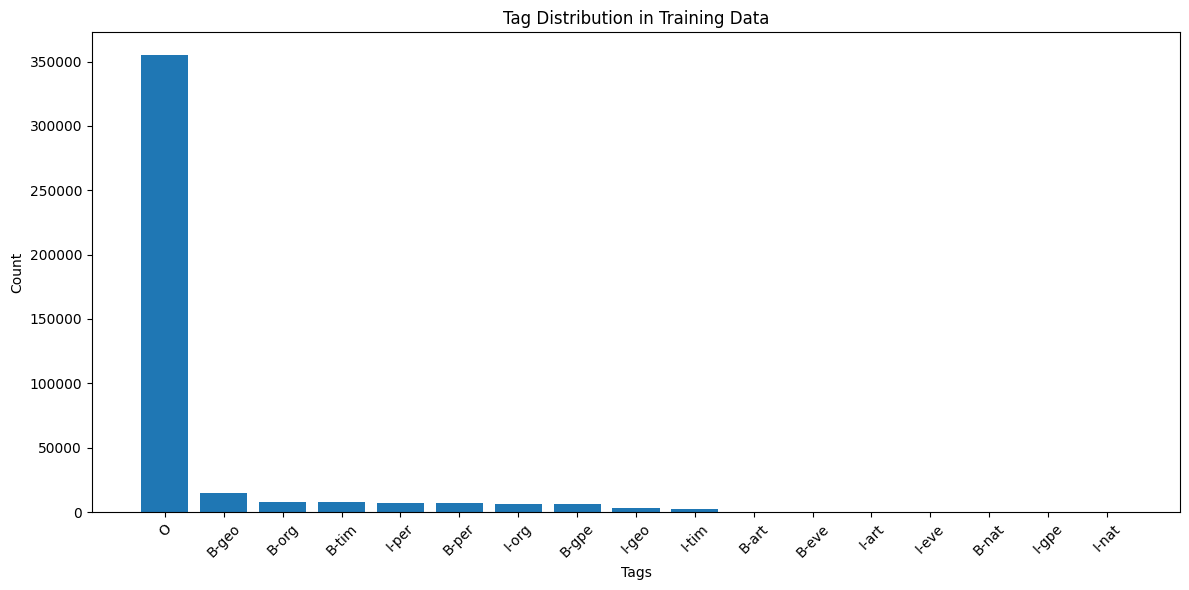

In [13]:
plt.figure(figsize=(12, 6))
tag_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['count'])
tag_df = tag_df.sort_values(by='count', ascending=False)

plt.bar(tag_df.index, tag_df['count'])
plt.title('Tag Distribution in Training Data')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

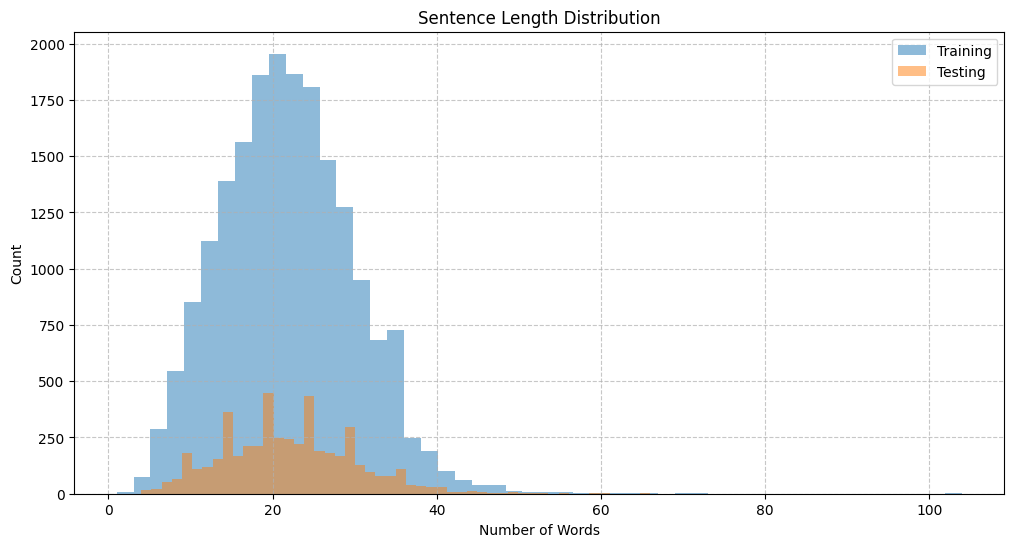

Average sentence length (train): 21.84 words
Average sentence length (test): 21.97 words
Maximum sentence length (train): 104 words
Maximum sentence length (test): 66 words


In [14]:
train_sent_lengths = [len(s) for s in train_sentences]
test_sent_lengths = [len(s) for s in test_sentences]

plt.figure(figsize=(12, 6))
plt.hist(train_sent_lengths, bins=50, alpha=0.5, label='Training')
plt.hist(test_sent_lengths, bins=50, alpha=0.5, label='Testing')
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print(f"Average sentence length (train): {np.mean(train_sent_lengths):.2f} words")
print(f"Average sentence length (test): {np.mean(test_sent_lengths):.2f} words")
print(f"Maximum sentence length (train): {max(train_sent_lengths)} words")
print(f"Maximum sentence length (test): {max(test_sent_lengths)} words")

In [15]:
all_words = [word.lower() for sentence in train_sentences for word in sentence]
word_counts = Counter(all_words)

print(f"Total vocabulary size: {len(word_counts)}")
print(f"Words that appear only once: {sum(1 for count in word_counts.values() if count == 1)}")

Total vocabulary size: 20943
Words that appear only once: 9020


In [16]:
vocab_size = 10000
word_tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
word_tokenizer.fit_on_texts([' '.join([w.lower() for w in sentence]) for sentence in train_sentences])

tag_to_idx = {tag: i for i, tag in enumerate(tag_counts.keys())}
idx_to_tag = {i: tag for tag, i in tag_to_idx.items()}
print(f"Number of unique tags: {len(tag_to_idx)}")

Number of unique tags: 17


In [17]:
def sentences_to_sequences(sentences, tokenizer):
    texts = [' '.join([w.lower() for w in s]) for s in sentences]
    return tokenizer.texts_to_sequences(texts)

def tags_to_sequences(tags_list, tag_to_idx):
    return [[tag_to_idx[tag] for tag in tags] for tags in tags_list]


train_sentence_sequences = sentences_to_sequences(train_sentences, word_tokenizer)
test_sentence_sequences = sentences_to_sequences(test_sentences, word_tokenizer)

train_tag_sequences = tags_to_sequences(train_tags, tag_to_idx)
test_tag_sequences = tags_to_sequences(test_tags, tag_to_idx)

In [18]:
max_len = max(max(len(s) for s in train_sentence_sequences),
              max(len(s) for s in test_sentence_sequences))

print(f"Maximum sequence length: {max_len}")

Maximum sequence length: 89


In [19]:
X_train = pad_sequences(train_sentence_sequences, maxlen=max_len, padding='post')
X_test = pad_sequences(test_sentence_sequences, maxlen=max_len, padding='post')

y_train = pad_sequences(train_tag_sequences, maxlen=max_len, padding='post')
y_test = pad_sequences(test_tag_sequences, maxlen=max_len, padding='post')

num_classes = len(tag_to_idx)
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train_oh.shape}")
print(f"Testing labels shape: {y_test_oh.shape}")


Training data shape: (19180, 89)
Testing data shape: (4796, 89)
Training labels shape: (19180, 89, 17)
Testing labels shape: (4796, 89, 17)


In [20]:
def create_mask(sequences):
    return np.array([np.array([1 if i < len(seq) else 0 for i in range(max_len)]) for seq in sequences])

train_mask = create_mask(train_sentence_sequences)
test_mask = create_mask(test_sentence_sequences)

print("Preprocessing Summary:")
print(f"1. Processed {len(train_sentences)} training sentences and {len(test_sentences)} testing sentences")
print(f"2. Vocabulary size: {min(len(word_tokenizer.word_index) + 1, vocab_size)}")
print(f"3. Number of unique tags: {num_classes}")
print(f"4. Maximum sequence length: {max_len}")
print(f"5. Training data shape: {X_train.shape}")
print(f"6. Testing data shape: {X_test.shape}")

Preprocessing Summary:
1. Processed 19180 training sentences and 4796 testing sentences
2. Vocabulary size: 10000
3. Number of unique tags: 17
4. Maximum sequence length: 89
5. Training data shape: (19180, 89)
6. Testing data shape: (4796, 89)


# Model Implementation

In [60]:
def evaluate_model(model, model_name, X_test, y_test_oh, test_mask):
    start_time = time.time()
    test_pred = model.predict(X_test)
    pred_time = time.time() - start_time
    test_pred_indices = np.argmax(test_pred, axis=-1)
    y_test_indices = np.argmax(y_test_oh, axis=-1)
    valid_predictions = []
    valid_targets = []

    for i in range(len(test_mask)):
        for j in range(len(test_mask[i])):
            if test_mask[i][j] == 1:
                valid_predictions.append(test_pred_indices[i][j])
                valid_targets.append(y_test_indices[i][j])

    accuracy = accuracy_score(valid_targets, valid_predictions)
    f1 = f1_score(valid_targets, valid_predictions, average='weighted')

    print(f"\n{model_name} Model Performance:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (weighted): {f1:.4f}")
    print(f"Prediction Time: {pred_time:.2f} seconds")

    report = classification_report(valid_targets, valid_predictions, target_names=list(tag_to_idx.keys()), zero_division=0)
    print(f"\nClassification Report for {model_name}:")
    print(report)

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'prediction_time': pred_time
    }

In [61]:
def create_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [62]:
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [63]:
def create_gru_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))
    model.add(Dropout(0.2))
    model.add(GRU(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [64]:
def create_bilstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [66]:
def plot_loss_curves(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_loss.png')
    plt.show()

In [68]:
def plot_confusion_matrix(y_true, y_pred, mask, model_name, class_names=None):
    valid_pred = []
    valid_true = []

    for i in range(len(mask)):
        for j in range(len(mask[i])):
            if mask[i][j] == 1:
                valid_pred.append(y_pred[i][j])
                valid_true.append(y_true[i][j])

    cm = confusion_matrix(valid_true, valid_pred)

    if class_names and len(class_names) > 15:
        top_classes_idx = np.bincount(valid_true, minlength=len(class_names)).argsort()[-15:][::-1]
        filtered_cm = cm[top_classes_idx][:, top_classes_idx]
        filtered_class_names = [class_names[i] for i in top_classes_idx]

        plt.figure(figsize=(14, 12))
        sns.heatmap(filtered_cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=filtered_class_names, yticklabels=filtered_class_names)
        plt.title(f'{model_name} - Confusion Matrix (Top 15 Classes)')
    else:
        plt.figure(figsize=(14, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{model_name} - Confusion Matrix')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')
    plt.show()

# Model Tranning (10 Epochs)


In [69]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]
results = []

In [70]:
print("\n===== Training Simple RNN Model =====")
rnn_model = create_rnn_model()
rnn_history = rnn_model.fit(
    X_train, y_train_oh,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)
rnn_model.summary()
rnn_results = evaluate_model(rnn_model, "Simple RNN", X_test, y_test_oh, test_mask)
results.append(rnn_results)


===== Training Simple RNN Model =====
Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9452 - loss: 0.3058

540/540 ━━━━━━━━━━━━━━━━━━━━ 62s 76ms/step - accuracy: 0.9452 - loss: 0.3056 - val_accuracy: 0.9698 - val_loss: 0.1157
Epoch 2/10
539/540 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9689 - loss: 0.1170

540/540 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.9690 - loss: 0.1170 - val_accuracy: 0.9717 - val_loss: 0.0973
Epoch 3/10
538/540 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9713 - loss: 0.0996

540/540 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9713 - loss: 0.0996 - val_accuracy: 0.9711 - val_loss: 0.0960
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9723 - loss: 0.0927

540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9724 - loss: 0.0927 - val_accuracy: 0.9716 - val_loss: 0.0945
Epoch 5/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9739 - loss: 0.0852 - val_accuracy: 0.9716 - val_loss: 0.0953
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9758 - loss: 0.0786 - val_accuracy: 0.9717 - val_loss: 0.0978
Epoch 7/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9773 - loss: 0.0727 - val_accuracy: 0.9718 - val_loss: 0.1012


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 89, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 89, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 89, 100)        │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 89, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 89, 17)         │         1,717 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,065,453 (11.69 MB)

 Trainable params: 1,021,817 (3.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,043,636 (7.80 MB)

150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step

Simple RNN Model Performance:
Test Accuracy: 0.8790
Test F1 Score (weighted): 0.8599
Prediction Time: 17.71 seconds

Classification Report for Simple RNN:
              precision    recall  f1-score   support

           O       0.90      0.98      0.94     82875
       B-tim       0.71      0.36      0.48      1928
       B-geo       0.56      0.30      0.39      3511
       B-gpe       0.78      0.41      0.54      1605
       B-org       0.53      0.21      0.30      1864
       I-org       0.58      0.27      0.37      1567
       I-geo       0.50      0.28      0.36       730
       B-per       0.65      0.40      0.50      1713
       I-per       0.67      0.57      0.62      1792
       I-tim       0.58      0.27      0.37       609
       B-art       0.00      0.00      0.00        38
       I-art       0.00      0.00      0.00        19
       B-nat       0.00      0.00      0.00        17
       B-eve       0.00      0.00      0.00 

In [71]:
print("\n===== Training LSTM Model =====")
lstm_model = create_lstm_model()

lstm_history = lstm_model.fit(
    X_train, y_train_oh,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)
lstm_model.summary()
lstm_results = evaluate_model(lstm_model, "LSTM", X_test, y_test_oh, test_mask)
results.append(lstm_results)


===== Training LSTM Model =====
Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.9489 - loss: 0.3687 - val_accuracy: 0.9643 - val_loss: 0.1427
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9641 - loss: 0.1406 - val_accuracy: 0.9698 - val_loss: 0.1073
Epoch 3/10
539/540 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9690 - loss: 0.1097

540/540 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9690 - loss: 0.1097 - val_accuracy: 0.9728 - val_loss: 0.0942
Epoch 4/10
537/540 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9716 - loss: 0.0967

540/540 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9716 - loss: 0.0967 - val_accuracy: 0.9742 - val_loss: 0.0887
Epoch 5/10
538/540 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9734 - loss: 0.0886

540/540 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9734 - loss: 0.0886 - val_accuracy: 0.9743 - val_loss: 0.0871
Epoch 6/10
538/540 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9748 - loss: 0.0831

540/540 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9748 - loss: 0.0831 - val_accuracy: 0.9746 - val_loss: 0.0871
Epoch 7/10
538/540 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9757 - loss: 0.0788

540/540 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9757 - loss: 0.0788 - val_accuracy: 0.9749 - val_loss: 0.0867
Epoch 8/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9763 - loss: 0.0754 - val_accuracy: 0.9752 - val_loss: 0.0879
Epoch 9/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9773 - loss: 0.0721 - val_accuracy: 0.9745 - val_loss: 0.0930
Epoch 10/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9781 - loss: 0.0692 - val_accuracy: 0.9750 - val_loss: 0.0897


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 89, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 89, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 89, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 89, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 89, 17)         │         1,717 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,246,353 (12.38 MB)

 Trainable params: 1,082,117 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,164,236 (8.26 MB)

150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step

LSTM Model Performance:
Test Accuracy: 0.8913
Test F1 Score (weighted): 0.8752
Prediction Time: 5.15 seconds

Classification Report for LSTM:
              precision    recall  f1-score   support

           O       0.91      0.98      0.95     82875
       B-tim       0.87      0.40      0.54      1928
       B-geo       0.69      0.35      0.46      3511
       B-gpe       0.81      0.53      0.64      1605
       B-org       0.57      0.27      0.36      1864
       I-org       0.58      0.32      0.42      1567
       I-geo       0.59      0.28      0.38       730
       B-per       0.65      0.46      0.54      1713
       I-per       0.68      0.62      0.65      1792
       I-tim       0.66      0.30      0.42       609
       B-art       0.00      0.00      0.00        38
       I-art       0.00      0.00      0.00        19
       B-nat       0.00      0.00      0.00        17
       B-eve       0.00      0.00      0.00        45
    

In [72]:
print("\n===== Training GRU Model =====")
gru_model = create_gru_model()

gru_history = gru_model.fit(
    X_train, y_train_oh,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)
gru_model.summary()
gru_results = evaluate_model(gru_model, "GRU", X_test, y_test_oh, test_mask)
results.append(gru_results)


===== Training GRU Model =====
Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9494 - loss: 0.3485 - val_accuracy: 0.9692 - val_loss: 0.1153
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9686 - loss: 0.1144 - val_accuracy: 0.9729 - val_loss: 0.0929
Epoch 3/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9715 - loss: 0.0964 - val_accuracy: 0.9739 - val_loss: 0.0870
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9733 - loss: 0.0879

540/540 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9733 - loss: 0.0879 - val_accuracy: 0.9748 - val_loss: 0.0844
Epoch 5/10
538/540 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9749 - loss: 0.0816

540/540 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9749 - loss: 0.0816 - val_accuracy: 0.9752 - val_loss: 0.0830
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9763 - loss: 0.0760 - val_accuracy: 0.9755 - val_loss: 0.0832
Epoch 7/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9773 - loss: 0.0720 - val_accuracy: 0.9754 - val_loss: 0.0879
Epoch 8/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9783 - loss: 0.0682 - val_accuracy: 0.9754 - val_loss: 0.0893


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 89, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 89, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 89, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 89, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 89, 17)         │         1,717 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,186,953 (12.16 MB)

 Trainable params: 1,062,317 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,124,636 (8.10 MB)

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

GRU Model Performance:
Test Accuracy: 0.8928
Test F1 Score (weighted): 0.8804
Prediction Time: 5.15 seconds

Classification Report for GRU:
              precision    recall  f1-score   support

           O       0.92      0.98      0.95     82875
       B-tim       0.83      0.45      0.58      1928
       B-geo       0.65      0.42      0.51      3511
       B-gpe       0.79      0.56      0.65      1605
       B-org       0.57      0.27      0.37      1864
       I-org       0.54      0.38      0.45      1567
       I-geo       0.53      0.32      0.40       730
       B-per       0.67      0.49      0.57      1713
       I-per       0.67      0.67      0.67      1792
       I-tim       0.59      0.35      0.44       609
       B-art       0.00      0.00      0.00        38
       I-art       0.00      0.00      0.00        19
       B-nat       0.00      0.00      0.00        17
       B-eve       1.00      0.04      0.09        45
      

In [73]:
print("\n===== Training BiLSTM Model =====")
bilstm_model = create_bilstm_model()

bilstm_history = bilstm_model.fit(
    X_train, y_train_oh,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

bilstm_model.summary()
bilstm_results = evaluate_model(bilstm_model, "BiLSTM", X_test, y_test_oh, test_mask)
results.append(bilstm_results)


===== Training BiLSTM Model =====
Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9498 - loss: 0.3087 - val_accuracy: 0.9677 - val_loss: 0.1151
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9678 - loss: 0.1130 - val_accuracy: 0.9730 - val_loss: 0.0901
Epoch 3/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9718 - loss: 0.0919

540/540 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9718 - loss: 0.0919 - val_accuracy: 0.9746 - val_loss: 0.0830
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9742 - loss: 0.0811

540/540 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9742 - loss: 0.0811 - val_accuracy: 0.9756 - val_loss: 0.0798
Epoch 5/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9763 - loss: 0.0728 - val_accuracy: 0.9758 - val_loss: 0.0807
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9780 - loss: 0.0664 - val_accuracy: 0.9758 - val_loss: 0.0825
Epoch 7/10
538/540 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9795 - loss: 0.0616

540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9795 - loss: 0.0616 - val_accuracy: 0.9760 - val_loss: 0.0796
Epoch 8/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9808 - loss: 0.0572 - val_accuracy: 0.9758 - val_loss: 0.0812
Epoch 9/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9820 - loss: 0.0532 - val_accuracy: 0.9763 - val_loss: 0.0833
Epoch 10/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9832 - loss: 0.0496 - val_accuracy: 0.9765 - val_loss: 0.0866


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 89, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 89, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 89, 200)        │       160,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 89, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 89, 17)         │         3,417 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,492,653 (13.32 MB)

 Trainable params: 1,164,217 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,328,436 (8.88 MB)

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step

BiLSTM Model Performance:
Test Accuracy: 0.8968
Test F1 Score (weighted): 0.8904
Prediction Time: 3.33 seconds

Classification Report for BiLSTM:
              precision    recall  f1-score   support

           O       0.94      0.97      0.95     82875
       B-tim       0.73      0.53      0.62      1928
       B-geo       0.62      0.54      0.57      3511
       B-gpe       0.76      0.62      0.68      1605
       B-org       0.52      0.40      0.45      1864
       I-org       0.54      0.44      0.49      1567
       I-geo       0.53      0.37      0.44       730
       B-per       0.65      0.53      0.58      1713
       I-per       0.67      0.69      0.68      1792
       I-tim       0.60      0.43      0.50       609
       B-art       0.00      0.00      0.00        38
       I-art       0.00      0.00      0.00        19
       B-nat       0.00      0.00      0.00        17
       B-eve       1.00      0.07      0.12        45


In [74]:
print("================ Model Comparison ================")
results_df = pd.DataFrame(results)
print(results_df[['model_name', 'accuracy', 'f1_score', 'prediction_time']])

================ Model Comparison ================
   model_name  accuracy  f1_score  prediction_time
0  Simple RNN  0.879043  0.859880        17.708351
1        LSTM  0.891271  0.875198         5.154294
2         GRU  0.892785  0.880407         5.151617
3      BiLSTM  0.896770  0.890430         3.328817


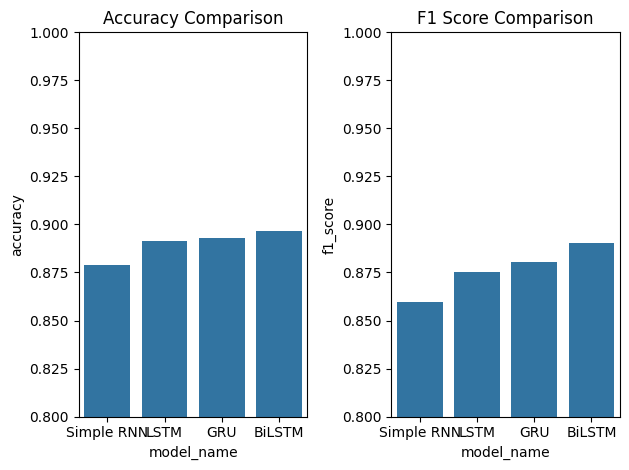

In [75]:
plt.subplot(1, 2, 1)
sns.barplot(x='model_name', y='accuracy', data=results_df)
plt.title('Accuracy Comparison')
plt.ylim(0.8, 1.0)  # Adjust as needed

plt.subplot(1, 2, 2)
sns.barplot(x='model_name', y='f1_score', data=results_df)
plt.title('F1 Score Comparison')
plt.ylim(0.8, 1.0)  # Adjust as needed

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

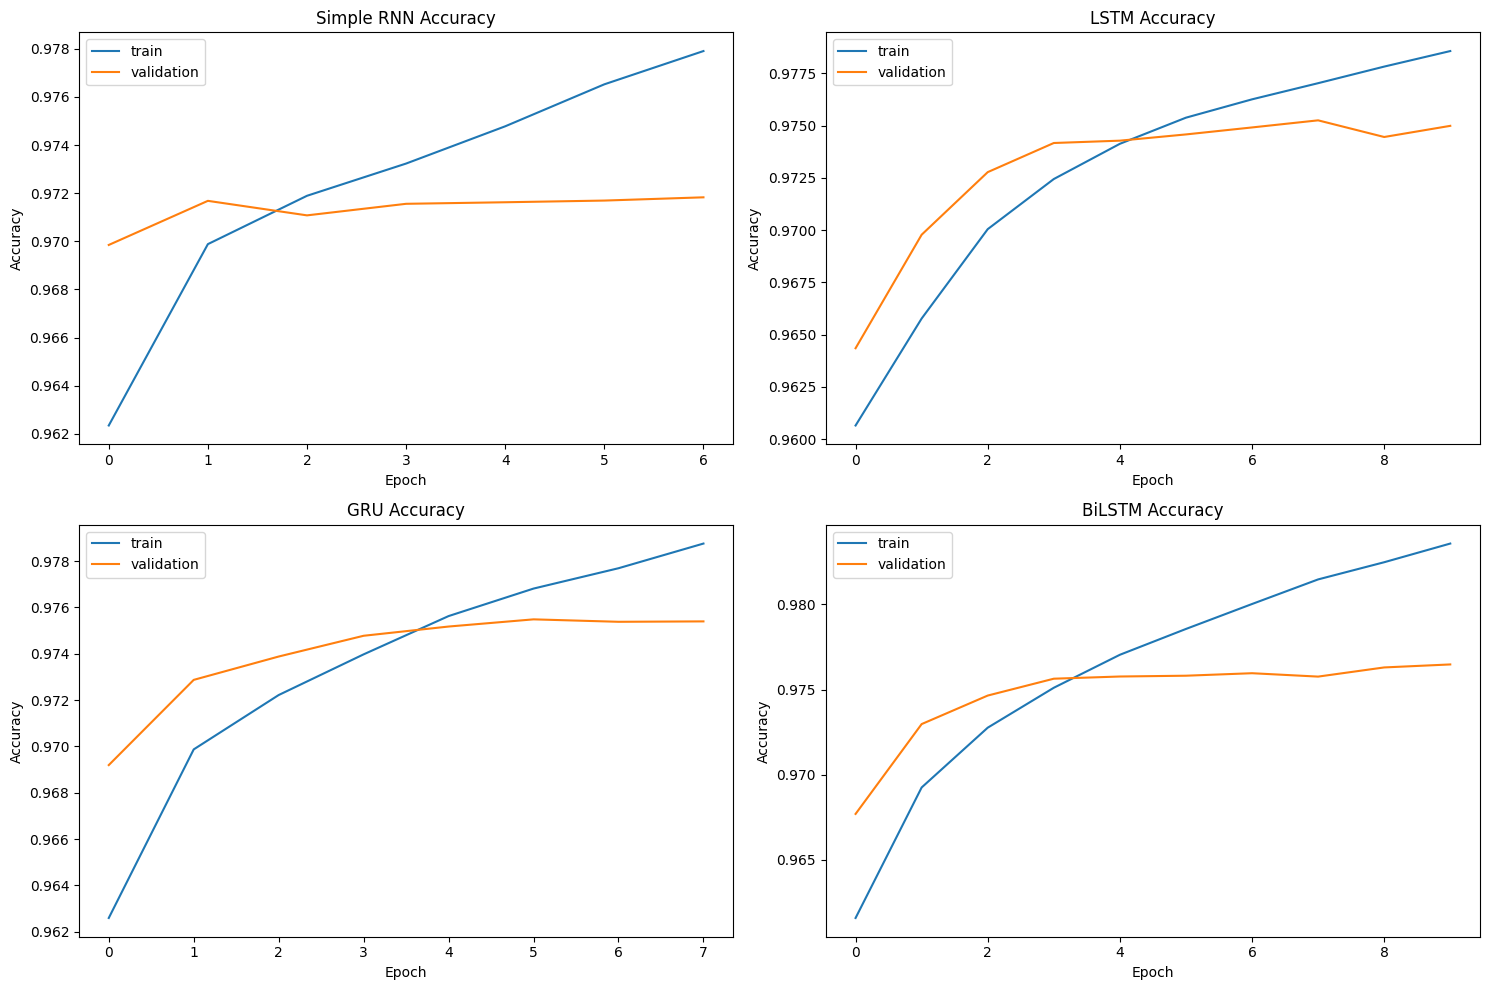

In [76]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='train')
plt.plot(rnn_history.history['val_accuracy'], label='validation')
plt.title('Simple RNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='train')
plt.plot(lstm_history.history['val_accuracy'], label='validation')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(gru_history.history['accuracy'], label='train')
plt.plot(gru_history.history['val_accuracy'], label='validation')
plt.title('GRU Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(2, 2, 4)
plt.plot(bilstm_history.history['accuracy'], label='train')
plt.plot(bilstm_history.history['val_accuracy'], label='validation')
plt.title('BiLSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Training loss Validation, Confusion matrix and Scatter plot


===== Evaluation for Simple RNN Model =====
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


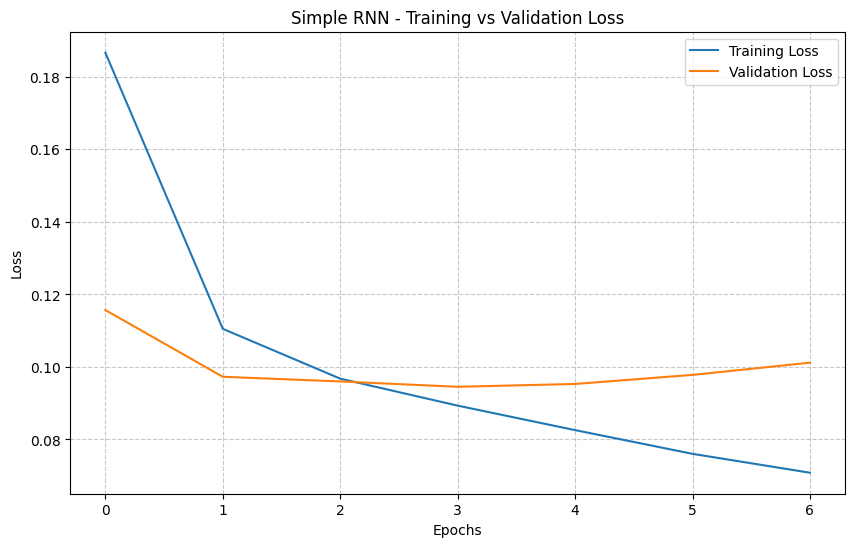

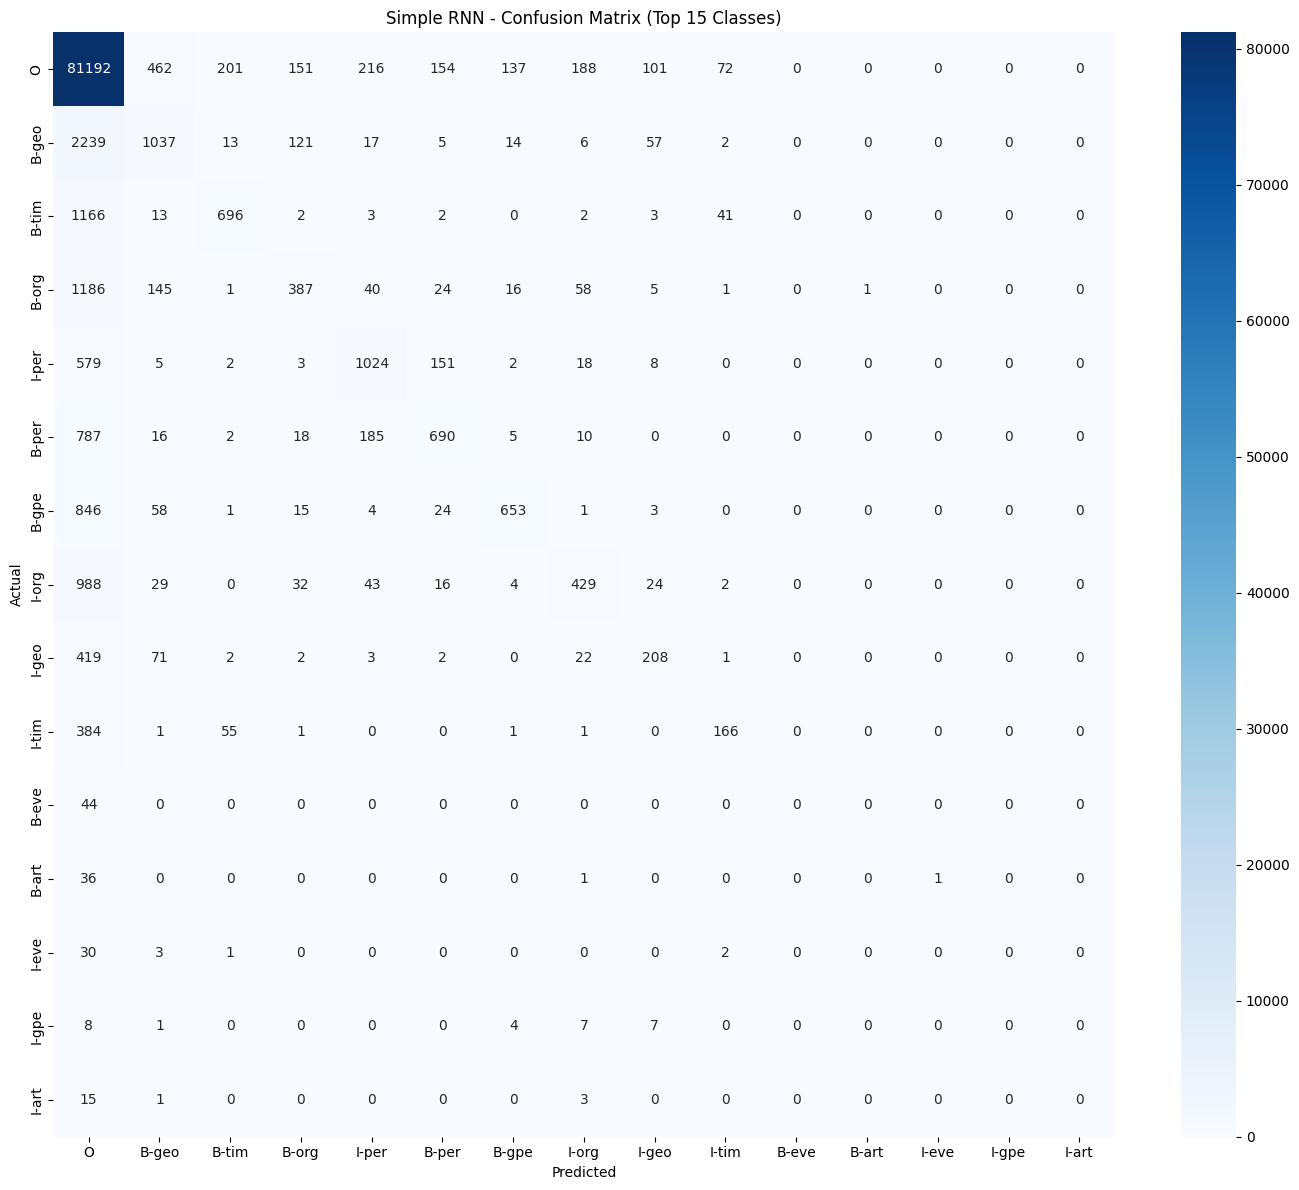

In [77]:
print("\n===== Evaluation for Simple RNN Model =====")
rnn_pred_indices = np.argmax(rnn_model.predict(X_test), axis=-1)
y_test_indices = np.argmax(y_test_oh, axis=-1)
plot_loss_curves(rnn_history, "Simple RNN")


plot_confusion_matrix(y_test_indices, rnn_pred_indices, test_mask, "Simple RNN", list(tag_to_idx.keys()))


===== Extended Evaluation for LSTM Model =====
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


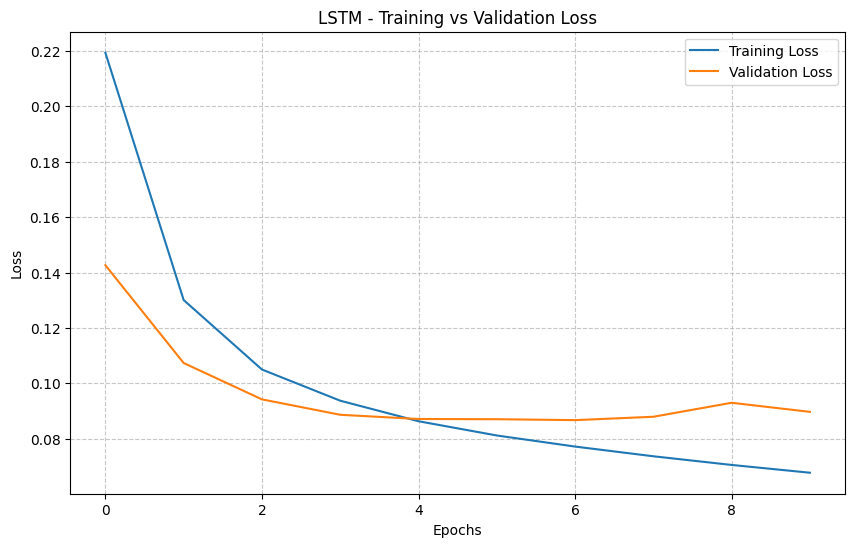

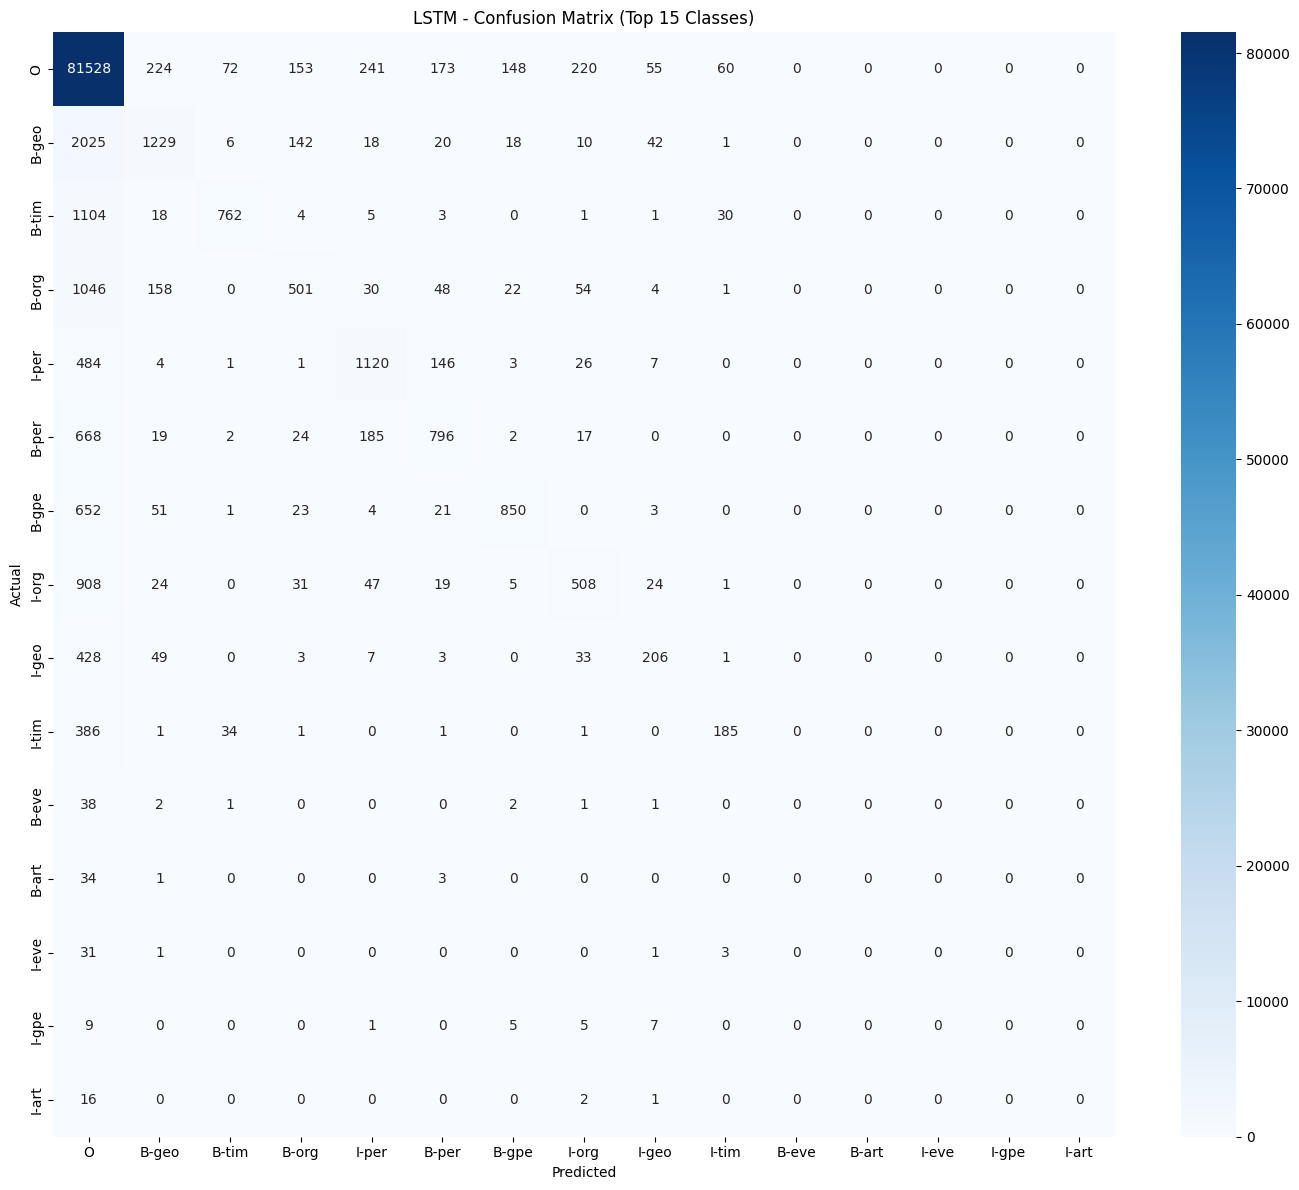

In [78]:
print("\n===== Extended Evaluation for LSTM Model =====")
lstm_pred_indices = np.argmax(lstm_model.predict(X_test), axis=-1)

plot_loss_curves(lstm_history, "LSTM")

plot_confusion_matrix(y_test_indices, lstm_pred_indices, test_mask, "LSTM", list(tag_to_idx.keys()))


===== Extended Evaluation for GRU Model =====
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


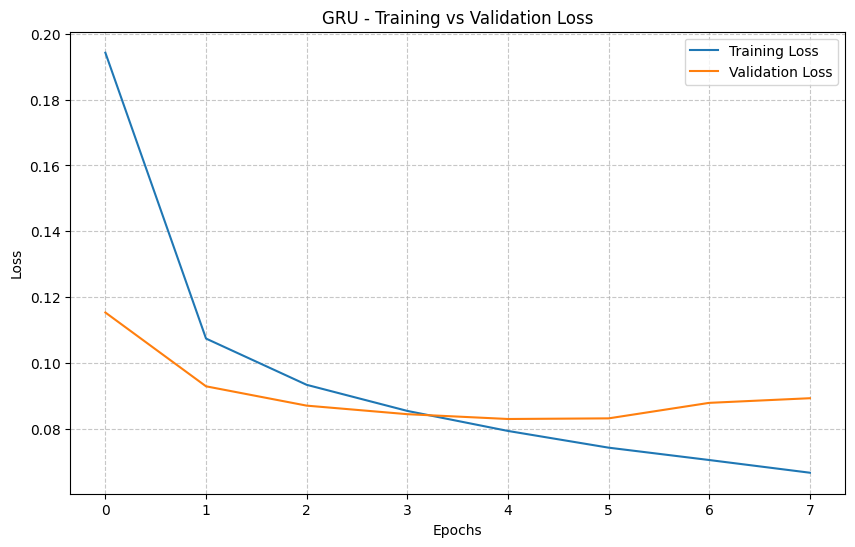

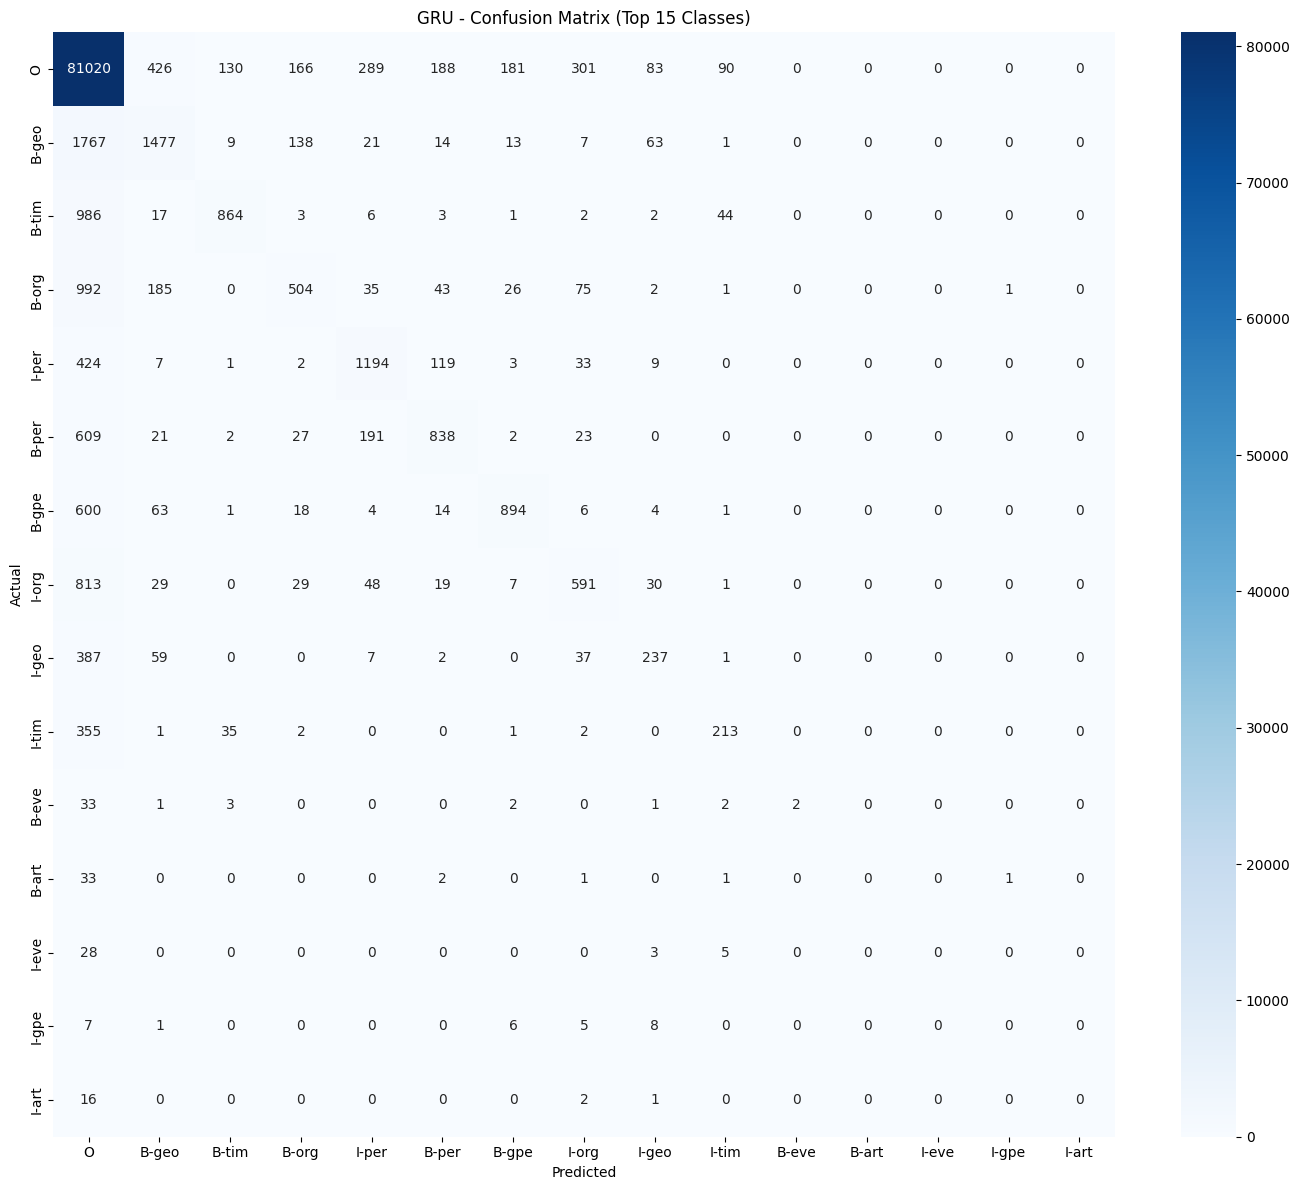

In [79]:
print("\n===== Extended Evaluation for GRU Model =====")
gru_pred_indices = np.argmax(gru_model.predict(X_test), axis=-1)
plot_loss_curves(gru_history, "GRU")
plot_confusion_matrix(y_test_indices, gru_pred_indices, test_mask, "GRU", list(tag_to_idx.keys()))


===== Extended Evaluation for BiLSTM Model =====
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


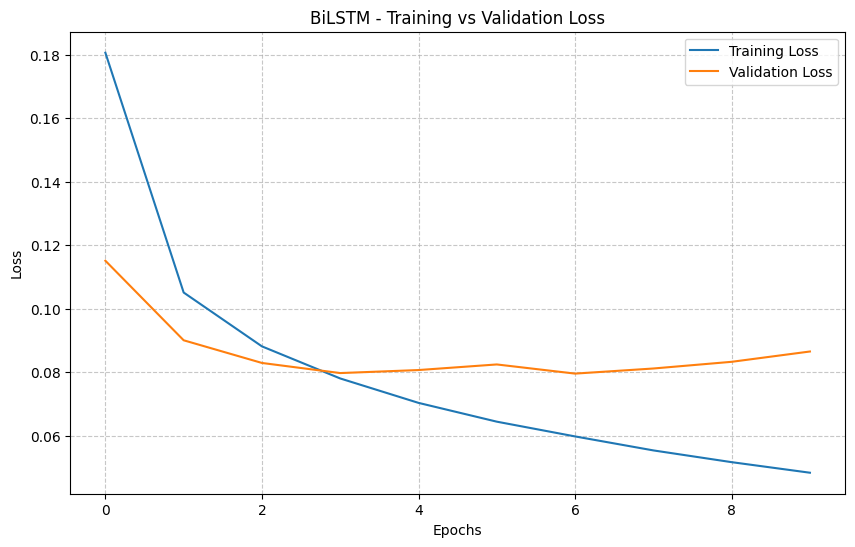

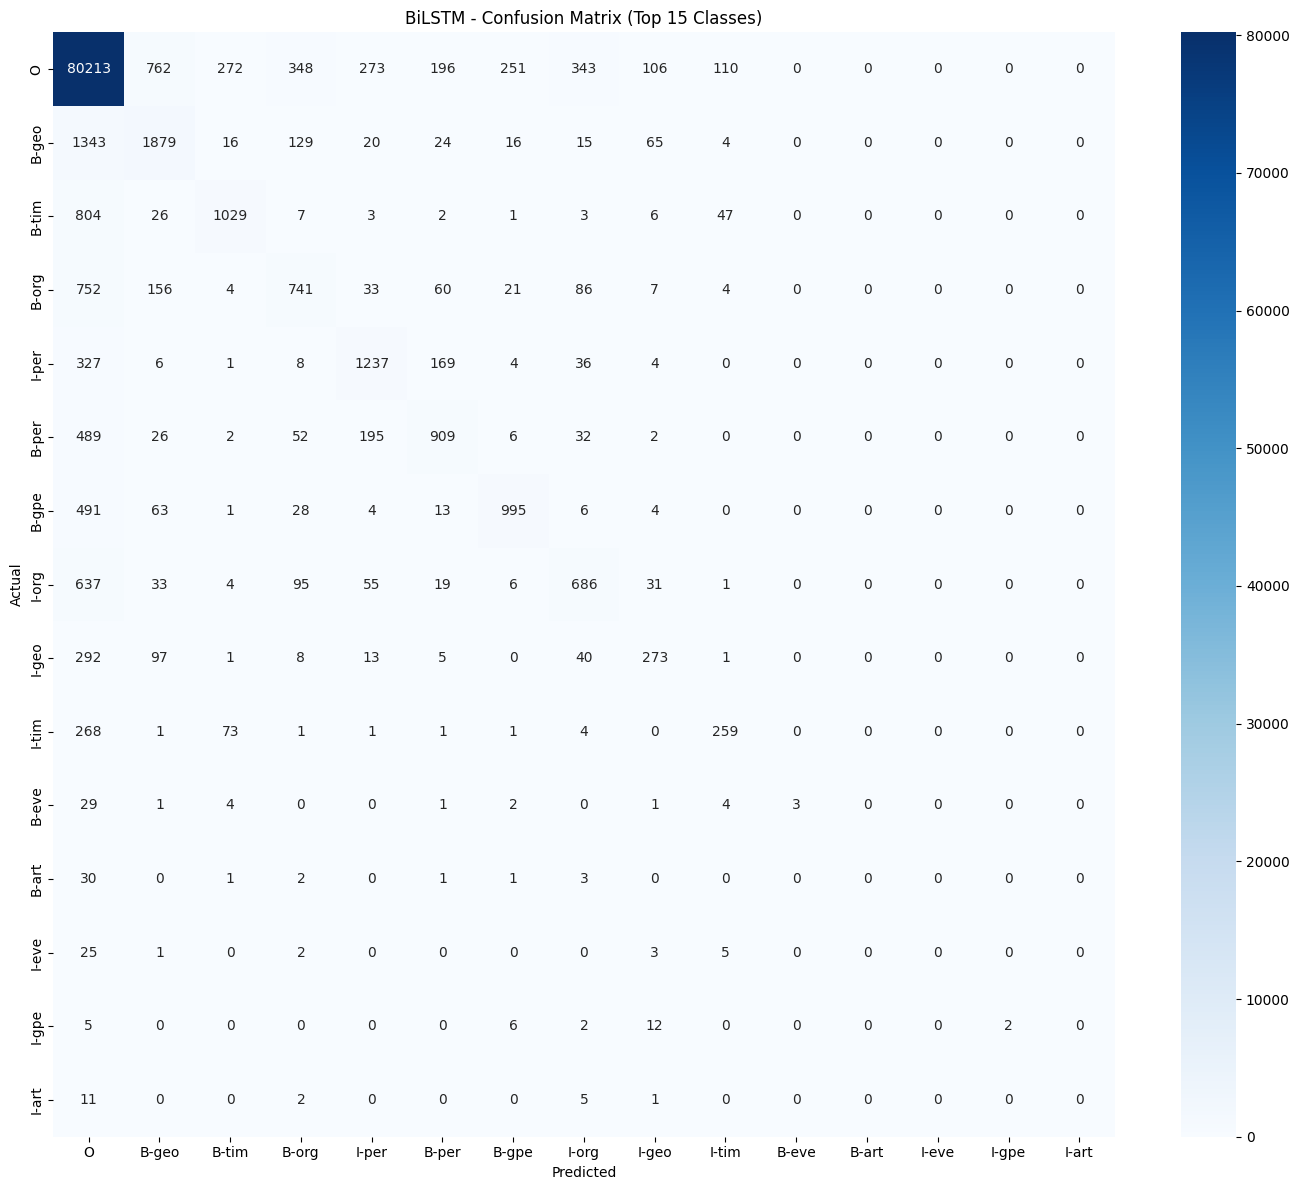

In [80]:
print("\n===== Extended Evaluation for BiLSTM Model =====")
bilstm_pred_indices = np.argmax(bilstm_model.predict(X_test), axis=-1)
plot_loss_curves(bilstm_history, "BiLSTM")
plot_confusion_matrix(y_test_indices, bilstm_pred_indices, test_mask, "BiLSTM", list(tag_to_idx.keys()))


===== Models Performance Comparison =====
        Model  Accuracy  F1 Score  Prediction Time (s)
0  Simple RNN  0.879043  0.859880            17.708351
1        LSTM  0.891271  0.875198             5.154294
2         GRU  0.892785  0.880407             5.151617
3      BiLSTM  0.896770  0.890430             3.328817


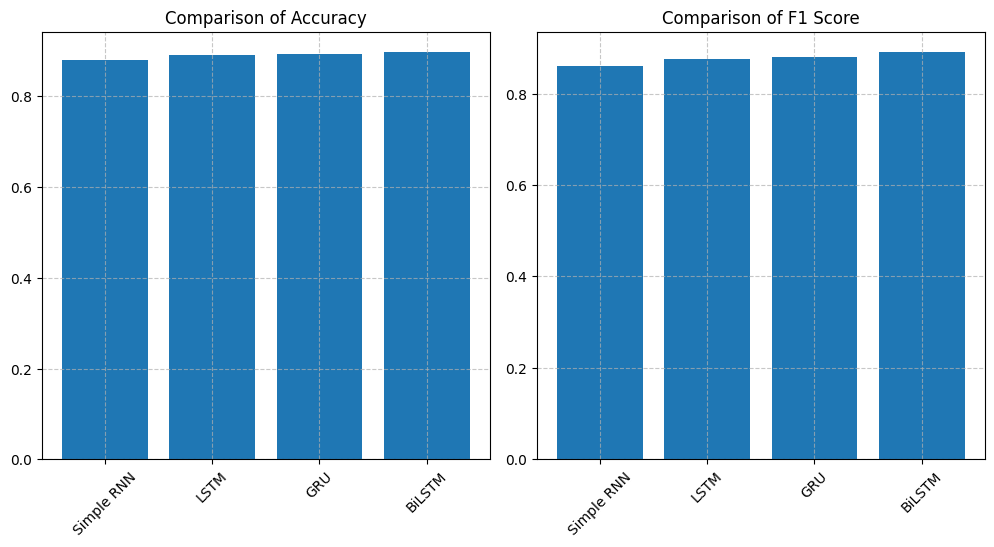

In [81]:
metrics_data = {
    'Model': ['Simple RNN', 'LSTM', 'GRU', 'BiLSTM'],
    'Accuracy': [rnn_results['accuracy'], lstm_results['accuracy'],
                gru_results['accuracy'], bilstm_results['accuracy']],
    'F1 Score': [rnn_results['f1_score'], lstm_results['f1_score'],
                gru_results['f1_score'], bilstm_results['f1_score']],
    'Prediction Time (s)': [rnn_results['prediction_time'], lstm_results['prediction_time'],
                          gru_results['prediction_time'], bilstm_results['prediction_time']]
}

metrics_df = pd.DataFrame(metrics_data)
print("\n===== Models Performance Comparison =====")
print(metrics_df)
metrics = ['Accuracy', 'F1 Score']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    plt.bar(metrics_df['Model'], metrics_df[metric])
    plt.title(f'Comparison of {metric}')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('model_metrics_comparison.png')
plt.show()

# **Hyperparameter Tuning**

# RNN

In [32]:
param_grid = {
    'batch_size': [64],
    'learning_rate': [0.005,0.0001],
    'rnn_units': [128],
    'embedding_dim': [128],
    'dropout_rate': [0.3]
}
parameter_combinations = list(ParameterGrid(param_grid))
print(f"Total parameter combinations to try: {len(parameter_combinations)}")

Total parameter combinations to try: 2


In [33]:
best_val_accuracy = 0
best_params = None
best_history = None
best_model = None
all_results = []

validation_split = 0.1
tuning_epochs = 15
for i, params in enumerate(parameter_combinations):
    print(f"\nTesting parameter combination {i+1}/{len(parameter_combinations)}")
    print(f"Parameters: {params}")

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                       output_dim=params['embedding_dim'],
                       input_length=max_len))
    model.add(Dropout(params['dropout_rate']))
    model.add(SimpleRNN(params['rnn_units'], return_sequences=True))
    model.add(Dropout(params['dropout_rate']))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy',
                                  patience=5,
                                  restore_best_weights=True,
                                  mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.2,
                                 patience=3,
                                 min_lr=1e-6)

    callbacks = [early_stopping, reduce_lr]

    start_time = time.time()
    history = model.fit(
        X_train, y_train_oh,
        validation_split=validation_split,
        epochs=tuning_epochs,
        batch_size=params['batch_size'],
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time

    val_accuracy = max(history.history['val_accuracy'])

    start_time = time.time()
    test_pred = model.predict(X_test)
    pred_time = time.time() - start_time

    test_pred_indices = np.argmax(test_pred, axis=-1)
    y_test_indices = np.argmax(y_test_oh, axis=-1)

    valid_predictions = []
    valid_targets = []

    for i in range(len(test_mask)):
        for j in range(len(test_mask[i])):
            if test_mask[i][j] == 1:  # Only consider non-padded values
                valid_predictions.append(test_pred_indices[i][j])
                valid_targets.append(y_test_indices[i][j])

    accuracy = accuracy_score(valid_targets, valid_predictions)
    f1 = f1_score(valid_targets, valid_predictions, average='weighted')

    print(f"RNN Model Evaluation:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (weighted): {f1:.4f}")
    print(f"Prediction Time: {pred_time:.2f} seconds")

    result = {
        'params': params,
        'best_val_accuracy': val_accuracy,
        'test_accuracy': accuracy,
        'test_f1': f1,
        'training_time': training_time,
        'history': history.history
    }
    all_results.append(result)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params
        best_history = history
        best_model = model
        best_model.save(f'best_rnn_model_{val_accuracy:.4f}.h5')

    print(f"Best validation accuracy: {val_accuracy:.4f}")
    print(f"Training time: {training_time:.2f} seconds")

print("\n===== Best RNN Model Parameters =====")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")
print(f"Best parameters: {best_params}")


Testing parameter combination 1/2
Parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'embedding_dim': 128, 'learning_rate': 0.005, 'rnn_units': 128}
Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 95s 263ms/step - accuracy: 0.9356 - loss: 0.3035 - val_accuracy: 0.9713 - val_loss: 0.1064 - learning_rate: 0.0050
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 55s 11ms/step - accuracy: 0.9697 - loss: 0.1126 - val_accuracy: 0.9728 - val_loss: 0.0947 - learning_rate: 0.0050
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9717 - loss: 0.0993 - val_accuracy: 0.9721 - val_loss: 0.0938 - learning_rate: 0.0050
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9723 - loss: 0.0942 - val_accuracy: 0.9733 - val_loss: 0.0907 - learning_rate: 0.0050
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9734 - loss: 0.0894 - val_accuracy: 0.9737 - val_loss: 0.0937 - learning_rate: 0.0050
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9745 - loss: 0

RNN Model Evaluation:
Test Accuracy: 0.8893
Test F1 Score (weighted): 0.8795
Prediction Time: 20.51 seconds
Best validation accuracy: 0.9742
Training time: 211.05 seconds

Testing parameter combination 2/2
Parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'embedding_dim': 128, 'learning_rate': 0.0001, 'rnn_units': 128}
Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 65s 169ms/step - accuracy: 0.9001 - loss: 0.7640 - val_accuracy: 0.9634 - val_loss: 0.2369 - learning_rate: 1.0000e-04
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9618 - loss: 0.2385 - val_accuracy: 0.9638 - val_loss: 0.2010 - learning_rate: 1.0000e-04
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9623 - loss: 0.2060 - val_accuracy: 0.9642 - val_loss: 0.1807 - learning_rate: 1.0000e-04
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9628 - loss: 0.1863 - val_accuracy: 0.9650 - val_loss: 0.1666 - learning_rate: 1.0000e-04
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 11m

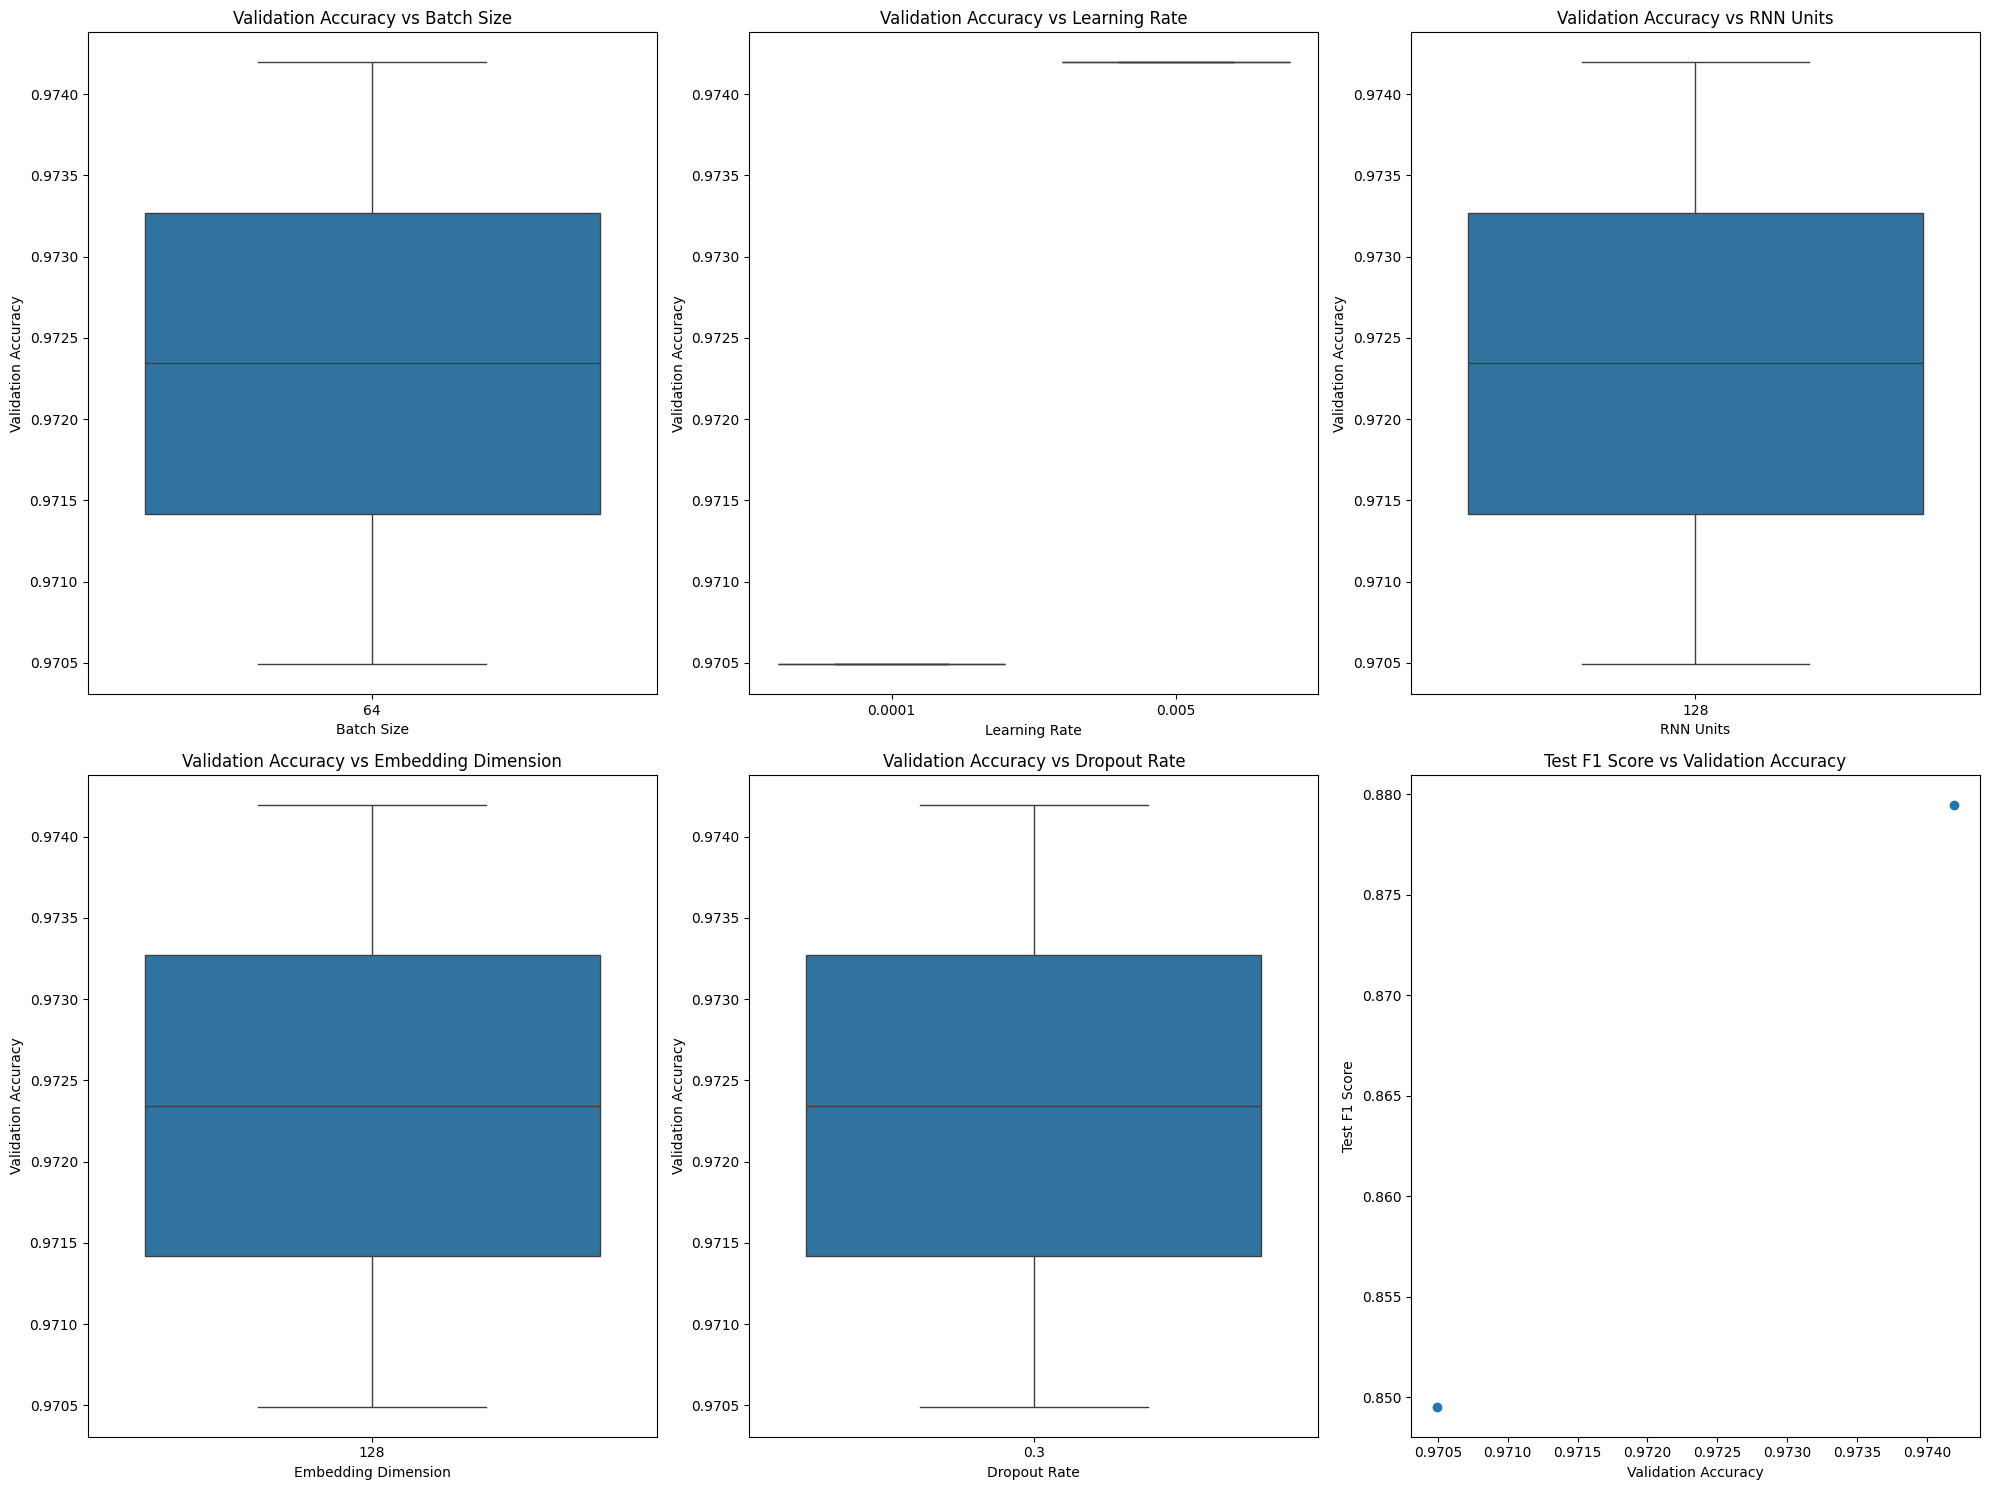

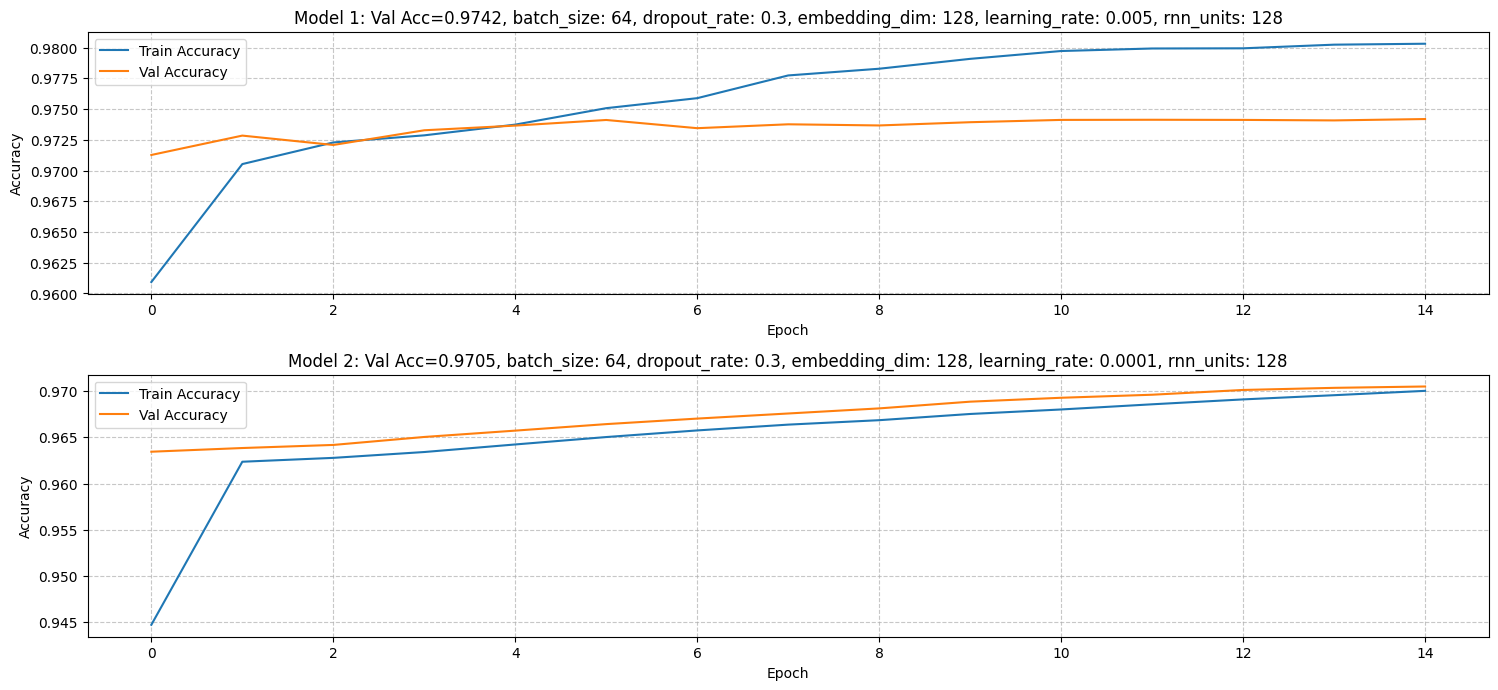

In [34]:
df = pd.DataFrame([
    {
        'batch_size': r['params']['batch_size'],
        'learning_rate': r['params']['learning_rate'],
        'rnn_units': r['params']['rnn_units'],
        'embedding_dim': r['params']['embedding_dim'],
        'dropout_rate': r['params']['dropout_rate'],
        'val_accuracy': r['best_val_accuracy'],
        'test_accuracy': r['test_accuracy'],
        'test_f1': r['test_f1'],
        'training_time': r['training_time']
    }
    for r in all_results
])

plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)
sns.boxplot(x='batch_size', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')

plt.subplot(2, 3, 2)
sns.boxplot(x='learning_rate', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')

plt.subplot(2, 3, 3)
sns.boxplot(x='rnn_units', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs RNN Units')
plt.xlabel('RNN Units')
plt.ylabel('Validation Accuracy')

plt.subplot(2, 3, 4)
sns.boxplot(x='embedding_dim', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Validation Accuracy')

plt.subplot(2, 3, 5)
sns.boxplot(x='dropout_rate', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Dropout Rate')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')

plt.subplot(2, 3, 6)
plt.scatter(df['val_accuracy'], df['test_f1'])
plt.title('Test F1 Score vs Validation Accuracy')
plt.xlabel('Validation Accuracy')
plt.ylabel('Test F1 Score')

plt.tight_layout()
plt.savefig('rnn_hyperparameter_tuning_results.png')
plt.show()

top_models = sorted(all_results, key=lambda x: x['best_val_accuracy'], reverse=True)[:3]

plt.figure(figsize=(15, 10))

for i, model in enumerate(top_models):
    plt.subplot(3, 1, i+1)
    params_str = ', '.join([f"{k}: {v}" for k, v in model['params'].items()])
    plt.plot(model['history']['accuracy'], label='Train Accuracy')
    plt.plot(model['history']['val_accuracy'], label='Val Accuracy')
    plt.title(f'Model {i+1}: Val Acc={model["best_val_accuracy"]:.4f}, {params_str}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('rnn_top_models_learning_curves.png')
plt.show()

# LSTM

In [35]:
lstm_param_grid = {
    'batch_size': [64],
    'learning_rate': [0.005,0.0001],
    'lstm_units': [128],
    'embedding_dim': [128],
    'dropout_rate': [0.3]
}

parameter_combinations = list(ParameterGrid(lstm_param_grid))
print(f"Total parameter combinations to try: {len(parameter_combinations)}")

Total parameter combinations to try: 2


In [36]:
best_val_accuracy = 0
best_params = None
best_history = None
best_model = None
all_results = []

validation_split = 0.1
tuning_epochs = 15


for i, params in enumerate(parameter_combinations):
    print(f"\nTesting parameter combination {i+1}/{len(parameter_combinations)}")
    print(f"Parameters: {params}")

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                       output_dim=params['embedding_dim'],
                       input_length=max_len))
    model.add(Dropout(params['dropout_rate']))
    model.add(LSTM(params['lstm_units'], return_sequences=True))
    model.add(Dropout(params['dropout_rate']))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy',
                                  patience=5,
                                  restore_best_weights=True,
                                  mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.2,
                                 patience=3,
                                 min_lr=1e-6)

    callbacks = [early_stopping, reduce_lr]


    start_time = time.time()
    history = model.fit(
        X_train, y_train_oh,
        validation_split=validation_split,
        epochs=tuning_epochs,
        batch_size=params['batch_size'],
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time


    val_accuracy = max(history.history['val_accuracy'])


    start_time = time.time()
    test_pred = model.predict(X_test)
    pred_time = time.time() - start_time

    test_pred_indices = np.argmax(test_pred, axis=-1)
    y_test_indices = np.argmax(y_test_oh, axis=-1)

    valid_predictions = []
    valid_targets = []

    for i in range(len(test_mask)):
        for j in range(len(test_mask[i])):
            if test_mask[i][j] == 1:  # Only consider non-padded values
                valid_predictions.append(test_pred_indices[i][j])
                valid_targets.append(y_test_indices[i][j])

    accuracy = accuracy_score(valid_targets, valid_predictions)
    f1 = f1_score(valid_targets, valid_predictions, average='weighted')

    print(f"LSTM Model Evaluation:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (weighted): {f1:.4f}")
    print(f"Prediction Time: {pred_time:.2f} seconds")

    result = {
        'params': params,
        'best_val_accuracy': val_accuracy,
        'test_accuracy': accuracy,
        'test_f1': f1,
        'training_time': training_time,
        'history': history.history
    }
    all_results.append(result)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params
        best_history = history
        best_model = model
        best_model.save(f'best_lstm_model_{val_accuracy:.4f}.h5')

    print(f"Best validation accuracy: {val_accuracy:.4f}")
    print(f"Training time: {training_time:.2f} seconds")

print("\n===== Best LSTM Model Parameters =====")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")
print(f"Best parameters: {best_params}")


Testing parameter combination 1/2
Parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'embedding_dim': 128, 'learning_rate': 0.005, 'lstm_units': 128}
Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9414 - loss: 0.2879 - val_accuracy: 0.9708 - val_loss: 0.1034 - learning_rate: 0.0050
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9696 - loss: 0.1080 - val_accuracy: 0.9736 - val_loss: 0.0896 - learning_rate: 0.0050
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9727 - loss: 0.0929 - val_accuracy: 0.9747 - val_loss: 0.0867 - learning_rate: 0.0050
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9746 - loss: 0.0839 - val_accuracy: 0.9753 - val_loss: 0.0861 - learning_rate: 0.0050
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9763 - loss: 0.0775 - val_accuracy: 0.9757 - val_loss: 0.0838 - learning_rate: 0.0050
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9775 - loss

LSTM Model Evaluation:
Test Accuracy: 0.8978
Test F1 Score (weighted): 0.8890
Prediction Time: 2.60 seconds
Best validation accuracy: 0.9762
Training time: 142.92 seconds

Testing parameter combination 2/2
Parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'embedding_dim': 128, 'learning_rate': 0.0001, 'lstm_units': 128}
Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9035 - loss: 1.1729 - val_accuracy: 0.9636 - val_loss: 0.2647 - learning_rate: 1.0000e-04
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9621 - loss: 0.2587 - val_accuracy: 0.9636 - val_loss: 0.2153 - learning_rate: 1.0000e-04
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9621 - loss: 0.2210 - val_accuracy: 0.9636 - val_loss: 0.1986 - learning_rate: 1.0000e-04
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9621 - loss: 0.2062 - val_accuracy: 0.9636 - val_loss: 0.1885 - learning_rate: 1.0000e-04
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 6s 23m

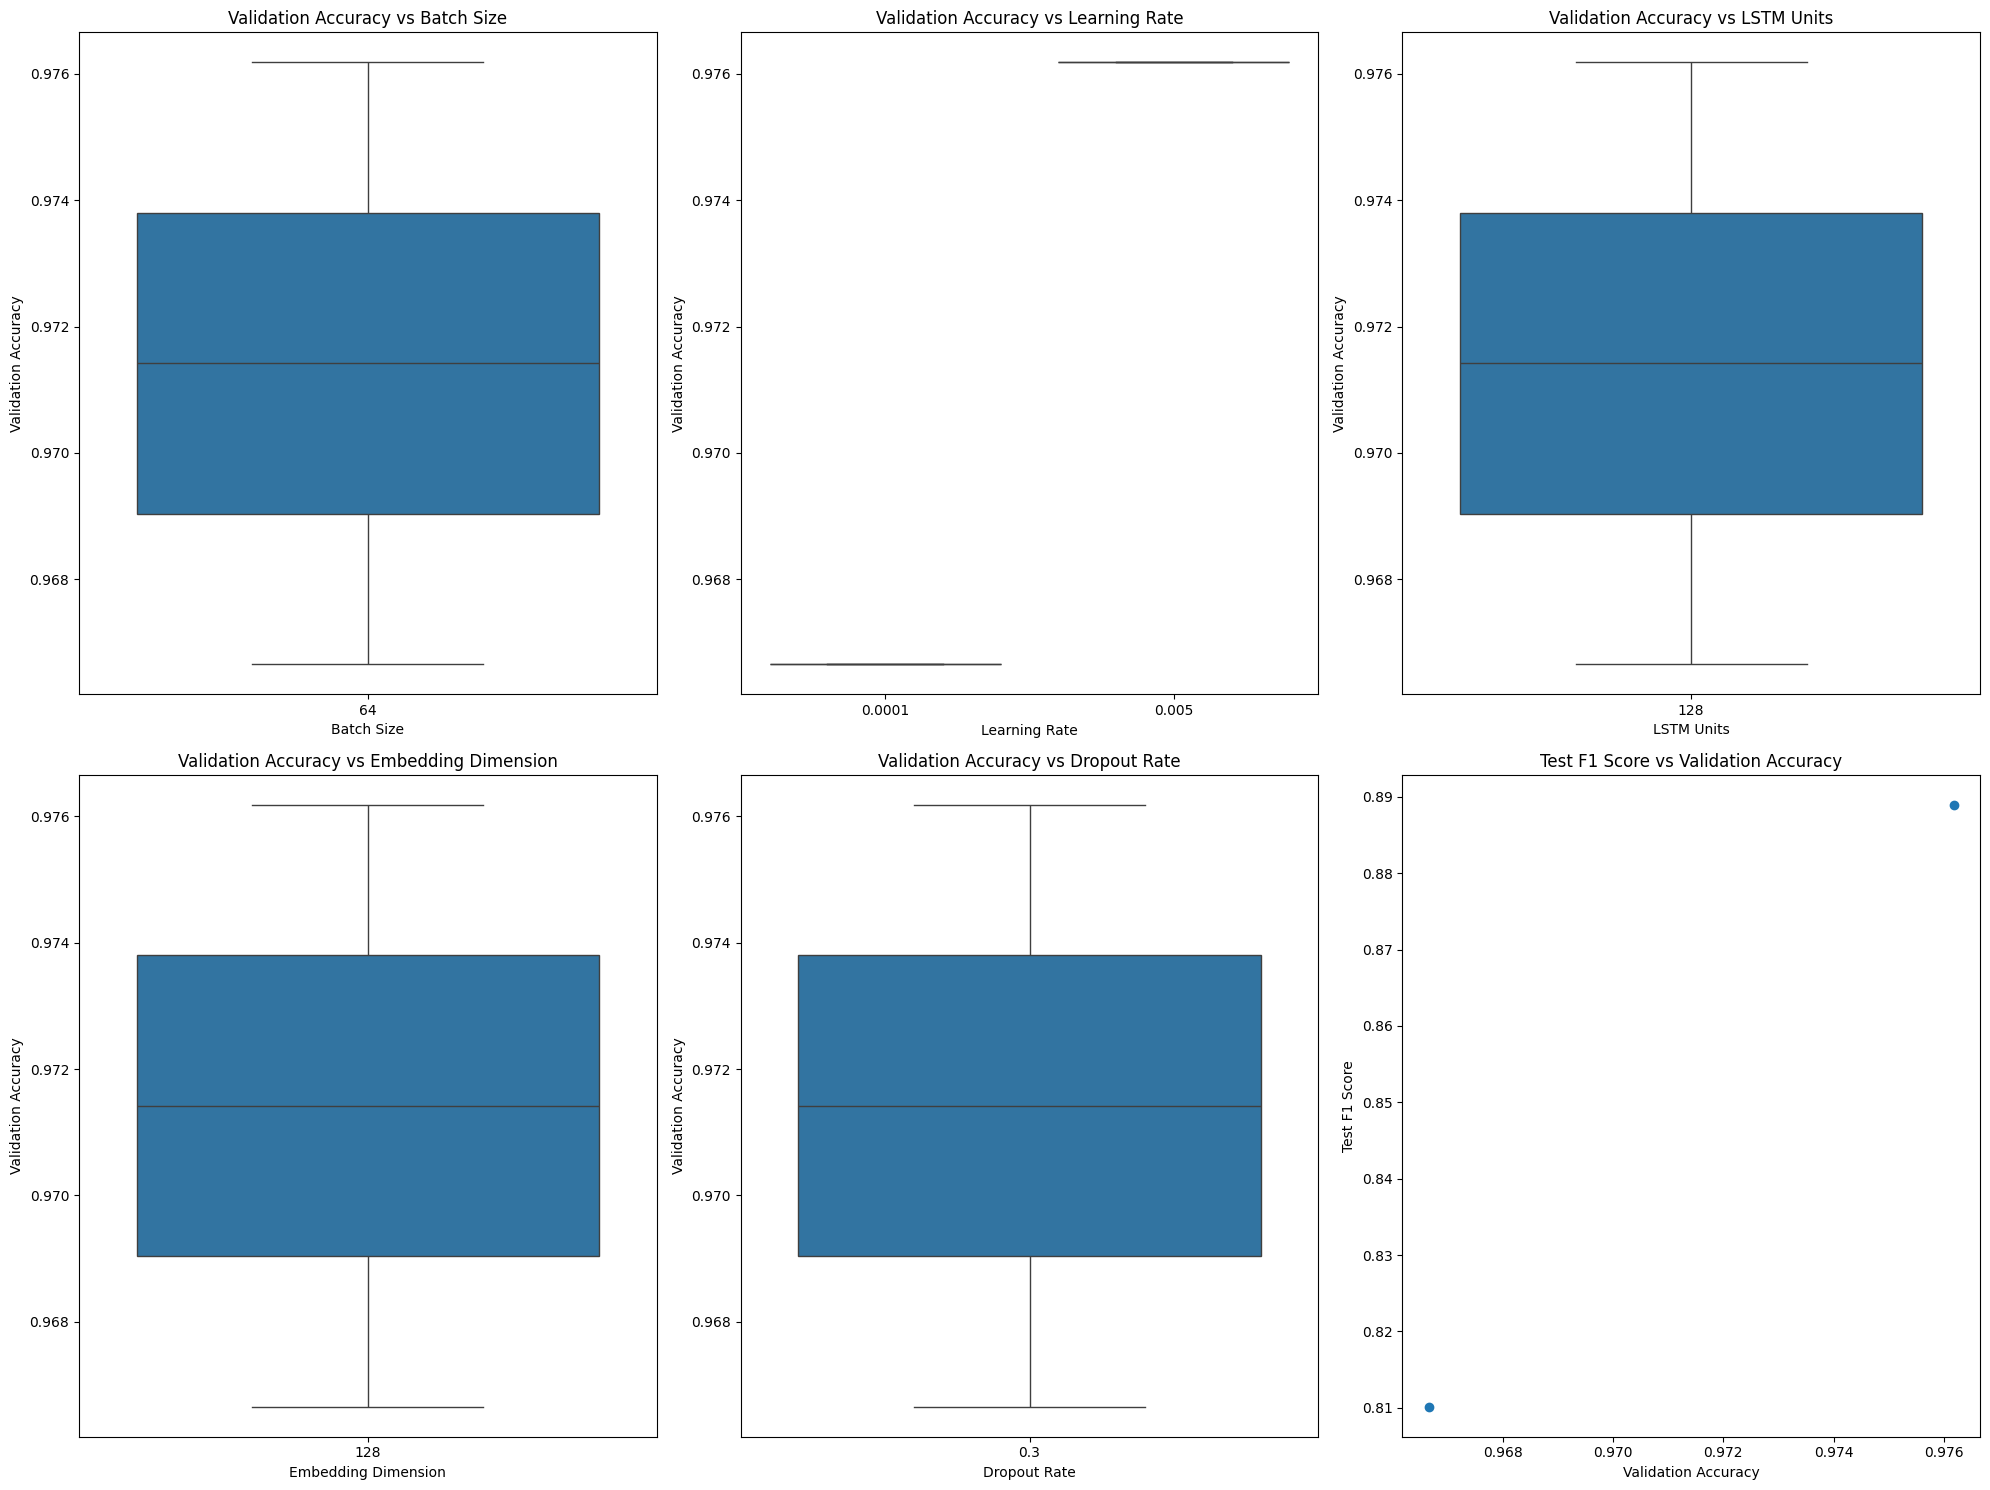

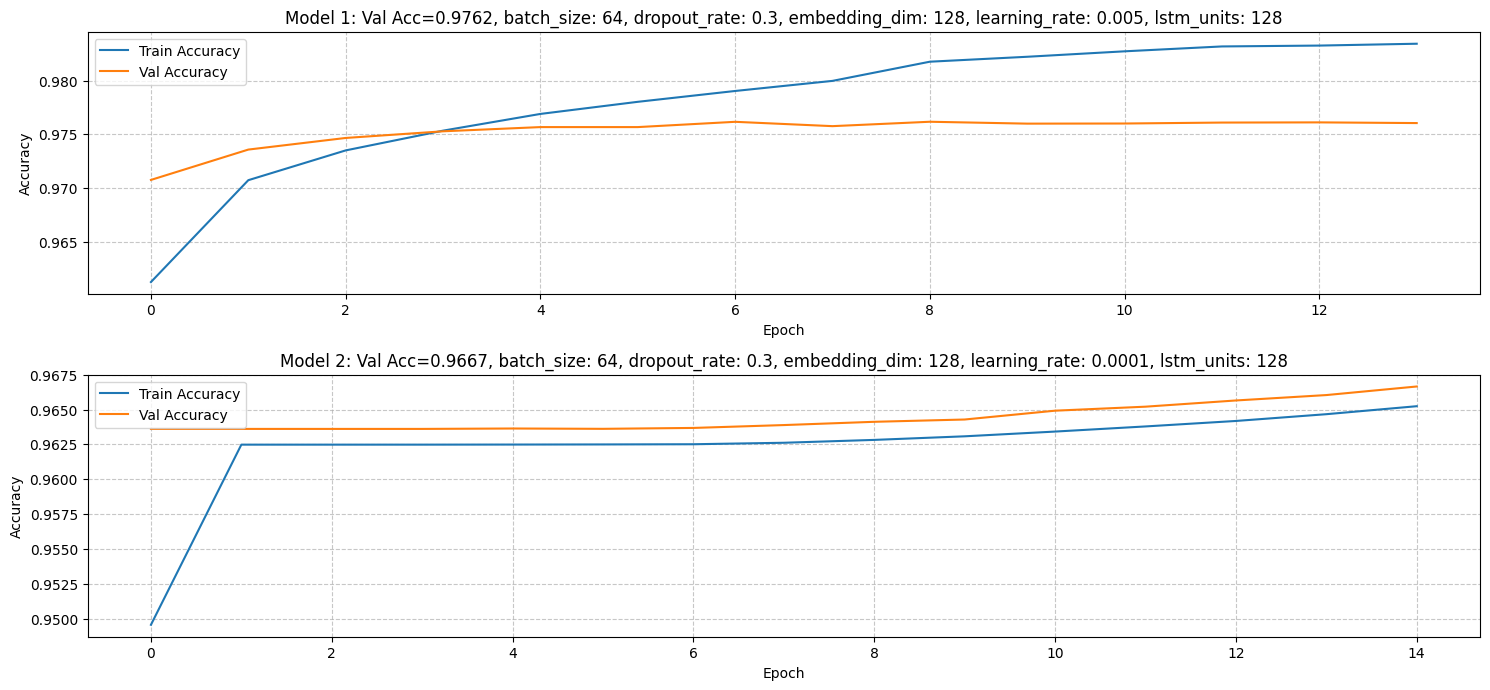

In [37]:
df = pd.DataFrame([
    {
        'batch_size': r['params']['batch_size'],
        'learning_rate': r['params']['learning_rate'],
        'lstm_units': r['params']['lstm_units'],
        'embedding_dim': r['params']['embedding_dim'],
        'dropout_rate': r['params']['dropout_rate'],
        'val_accuracy': r['best_val_accuracy'],
        'test_accuracy': r['test_accuracy'],
        'test_f1': r['test_f1'],
        'training_time': r['training_time']
    }
    for r in all_results
])


plt.figure(figsize=(20, 15))


plt.subplot(2, 3, 1)
sns.boxplot(x='batch_size', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')


plt.subplot(2, 3, 2)
sns.boxplot(x='learning_rate', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')


plt.subplot(2, 3, 3)
sns.boxplot(x='lstm_units', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs LSTM Units')
plt.xlabel('LSTM Units')
plt.ylabel('Validation Accuracy')


plt.subplot(2, 3, 4)
sns.boxplot(x='embedding_dim', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Validation Accuracy')


plt.subplot(2, 3, 5)
sns.boxplot(x='dropout_rate', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Dropout Rate')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')


plt.subplot(2, 3, 6)
plt.scatter(df['val_accuracy'], df['test_f1'])
plt.title('Test F1 Score vs Validation Accuracy')
plt.xlabel('Validation Accuracy')
plt.ylabel('Test F1 Score')

plt.tight_layout()
plt.savefig('lstm_hyperparameter_tuning_results.png')
plt.show()


top_models = sorted(all_results, key=lambda x: x['best_val_accuracy'], reverse=True)[:3]

plt.figure(figsize=(15, 10))

for i, model in enumerate(top_models):
    plt.subplot(3, 1, i+1)
    params_str = ', '.join([f"{k}: {v}" for k, v in model['params'].items()])
    plt.plot(model['history']['accuracy'], label='Train Accuracy')
    plt.plot(model['history']['val_accuracy'], label='Val Accuracy')
    plt.title(f'Model {i+1}: Val Acc={model["best_val_accuracy"]:.4f}, {params_str}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('lstm_top_models_learning_curves.png')
plt.show()

# GRU

In [38]:
gru_param_grid = {
    'batch_size': [64],
    'learning_rate': [0.005,0.0001],
    'gru_units': [128],
    'embedding_dim': [128],
    'dropout_rate': [0.3]
}

parameter_combinations = list(ParameterGrid(gru_param_grid))
print(f"Total parameter combinations to try: {len(parameter_combinations)}")

Total parameter combinations to try: 2


In [39]:
best_val_accuracy = 0
best_params = None
best_history = None
best_model = None
all_results = []

validation_split = 0.1
tuning_epochs = 15


for i, params in enumerate(parameter_combinations):
    print(f"\nTesting parameter combination {i+1}/{len(parameter_combinations)}")
    print(f"Parameters: {params}")


    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                       output_dim=params['embedding_dim'],
                       input_length=max_len))
    model.add(Dropout(params['dropout_rate']))
    model.add(GRU(params['gru_units'], return_sequences=True))
    model.add(Dropout(params['dropout_rate']))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy',
                                  patience=5,
                                  restore_best_weights=True,
                                  mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.2,
                                 patience=3,
                                 min_lr=1e-6)

    callbacks = [early_stopping, reduce_lr]

    start_time = time.time()
    history = model.fit(
        X_train, y_train_oh,
        validation_split=validation_split,
        epochs=tuning_epochs,
        batch_size=params['batch_size'],
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time

    val_accuracy = max(history.history['val_accuracy'])

    start_time = time.time()
    test_pred = model.predict(X_test)
    pred_time = time.time() - start_time

    test_pred_indices = np.argmax(test_pred, axis=-1)
    y_test_indices = np.argmax(y_test_oh, axis=-1)

    valid_predictions = []
    valid_targets = []

    for i in range(len(test_mask)):
        for j in range(len(test_mask[i])):
            if test_mask[i][j] == 1:
                valid_predictions.append(test_pred_indices[i][j])
                valid_targets.append(y_test_indices[i][j])

    accuracy = accuracy_score(valid_targets, valid_predictions)
    f1 = f1_score(valid_targets, valid_predictions, average='weighted')

    print(f"GRU Model Evaluation:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (weighted): {f1:.4f}")
    print(f"Prediction Time: {pred_time:.2f} seconds")

    result = {
        'params': params,
        'best_val_accuracy': val_accuracy,
        'test_accuracy': accuracy,
        'test_f1': f1,
        'training_time': training_time,
        'history': history.history
    }
    all_results.append(result)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params
        best_history = history
        best_model = model
        best_model.save(f'best_gru_model_{val_accuracy:.4f}.h5')

    print(f"Best validation accuracy: {val_accuracy:.4f}")
    print(f"Training time: {training_time:.2f} seconds")

print("\n===== Best GRU Model Parameters =====")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")
print(f"Best parameters: {best_params}")


Testing parameter combination 1/2
Parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'embedding_dim': 128, 'gru_units': 128, 'learning_rate': 0.005}
Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9431 - loss: 0.2633 - val_accuracy: 0.9736 - val_loss: 0.0915 - learning_rate: 0.0050
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9720 - loss: 0.0970 - val_accuracy: 0.9748 - val_loss: 0.0850 - learning_rate: 0.0050
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9743 - loss: 0.0856 - val_accuracy: 0.9752 - val_loss: 0.0855 - learning_rate: 0.0050
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9761 - loss: 0.0781 - val_accuracy: 0.9759 - val_loss: 0.0831 - learning_rate: 0.0050
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9772 - loss: 0.0731 - val_accuracy: 0.9756 - val_loss: 0.0841 - learning_rate: 0.0050
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.9783 - loss: 

GRU Model Evaluation:
Test Accuracy: 0.8986
Test F1 Score (weighted): 0.8907
Prediction Time: 5.18 seconds
Best validation accuracy: 0.9762
Training time: 95.43 seconds

Testing parameter combination 2/2
Parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'embedding_dim': 128, 'gru_units': 128, 'learning_rate': 0.0001}
Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.9058 - loss: 1.1457 - val_accuracy: 0.9636 - val_loss: 0.2367 - learning_rate: 1.0000e-04
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9621 - loss: 0.2330 - val_accuracy: 0.9636 - val_loss: 0.1980 - learning_rate: 1.0000e-04
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9621 - loss: 0.2019 - val_accuracy: 0.9637 - val_loss: 0.1813 - learning_rate: 1.0000e-04
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9622 - loss: 0.1870 - val_accuracy: 0.9641 - val_loss: 0.1704 - learning_rate: 1.0000e-04
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/s

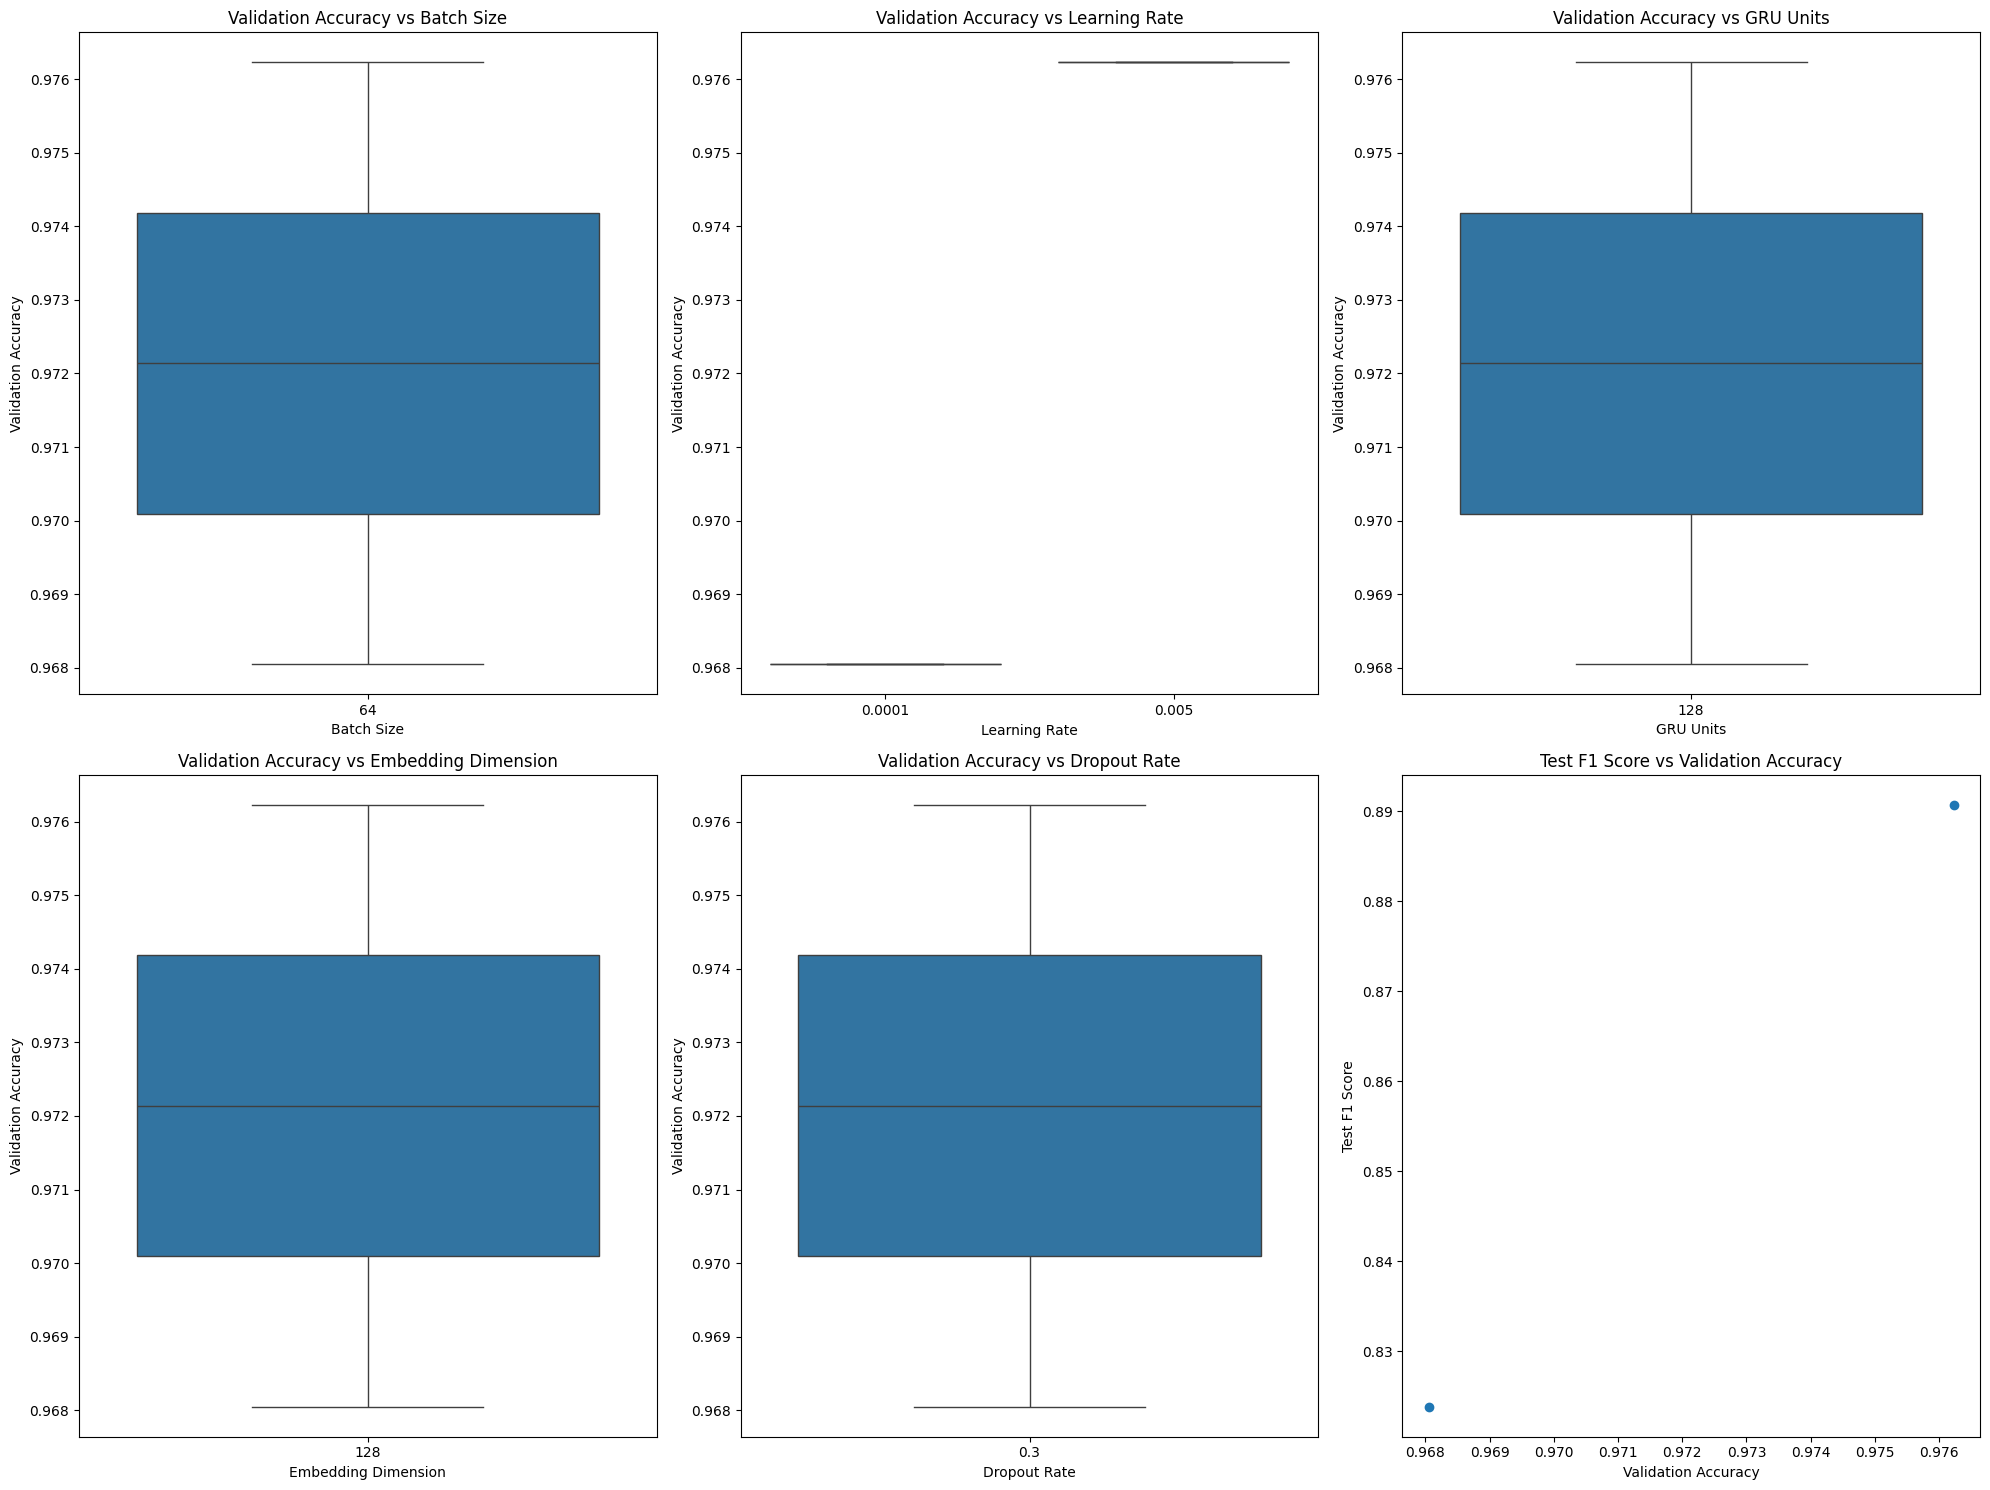

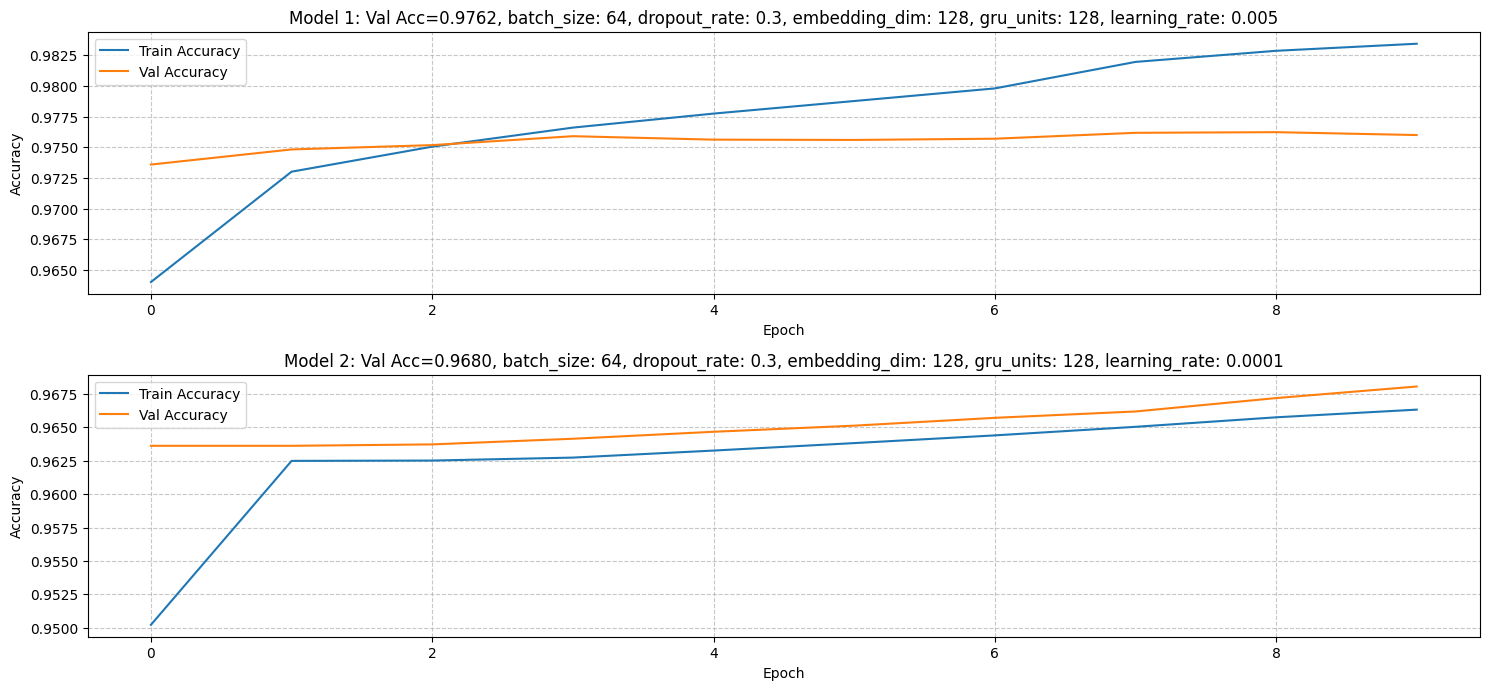

In [40]:
df = pd.DataFrame([
    {
        'batch_size': r['params']['batch_size'],
        'learning_rate': r['params']['learning_rate'],
        'gru_units': r['params']['gru_units'],
        'embedding_dim': r['params']['embedding_dim'],
        'dropout_rate': r['params']['dropout_rate'],
        'val_accuracy': r['best_val_accuracy'],
        'test_accuracy': r['test_accuracy'],
        'test_f1': r['test_f1'],
        'training_time': r['training_time']
    }
    for r in all_results
])

plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)
sns.boxplot(x='batch_size', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')

plt.subplot(2, 3, 2)
sns.boxplot(x='learning_rate', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')

plt.subplot(2, 3, 3)
sns.boxplot(x='gru_units', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs GRU Units')
plt.xlabel('GRU Units')
plt.ylabel('Validation Accuracy')

plt.subplot(2, 3, 4)
sns.boxplot(x='embedding_dim', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Validation Accuracy')

plt.subplot(2, 3, 5)
sns.boxplot(x='dropout_rate', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Dropout Rate')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')

plt.subplot(2, 3, 6)
plt.scatter(df['val_accuracy'], df['test_f1'])
plt.title('Test F1 Score vs Validation Accuracy')
plt.xlabel('Validation Accuracy')
plt.ylabel('Test F1 Score')

plt.tight_layout()
plt.savefig('gru_hyperparameter_tuning_results.png')
plt.show()

top_models = sorted(all_results, key=lambda x: x['best_val_accuracy'], reverse=True)[:3]

plt.figure(figsize=(15, 10))

for i, model in enumerate(top_models):
    plt.subplot(3, 1, i+1)

    params_str = ', '.join([f"{k}: {v}" for k, v in model['params'].items()])

    plt.plot(model['history']['accuracy'], label='Train Accuracy')
    plt.plot(model['history']['val_accuracy'], label='Val Accuracy')
    plt.title(f'Model {i+1}: Val Acc={model["best_val_accuracy"]:.4f}, {params_str}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('gru_top_models_learning_curves.png')
plt.show()

# BiLSTM

In [43]:
bilstm_param_grid = {
    'batch_size': [64],
    'learning_rate': [0.005,0.0001],
    'lstm_units': [128],
    'embedding_dim': [128],
    'dropout_rate': [0.3]
}
parameter_combinations = list(ParameterGrid(bilstm_param_grid))
print(f"Total parameter combinations to try: {len(parameter_combinations)}")

Total parameter combinations to try: 2


In [44]:
best_val_accuracy = 0
best_params = None
best_history = None
best_model = None
all_results = []

validation_split = 0.1
tuning_epochs = 15


for i, params in enumerate(parameter_combinations):
    print(f"\nTesting parameter combination {i+1}/{len(parameter_combinations)}")
    print(f"Parameters: {params}")

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                       output_dim=params['embedding_dim'],
                       input_length=max_len))
    model.add(Dropout(params['dropout_rate']))
    model.add(Bidirectional(LSTM(params['lstm_units'], return_sequences=True)))
    model.add(Dropout(params['dropout_rate']))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy',
                                  patience=5,
                                  restore_best_weights=True,
                                  mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.2,
                                 patience=3,
                                 min_lr=1e-6)

    callbacks = [early_stopping, reduce_lr]

    start_time = time.time()
    history = model.fit(
        X_train, y_train_oh,
        validation_split=validation_split,
        epochs=tuning_epochs,
        batch_size=params['batch_size'],
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time

    val_accuracy = max(history.history['val_accuracy'])

    start_time = time.time()
    test_pred = model.predict(X_test)
    pred_time = time.time() - start_time

    test_pred_indices = np.argmax(test_pred, axis=-1)
    y_test_indices = np.argmax(y_test_oh, axis=-1)

    valid_predictions = []
    valid_targets = []

    for i in range(len(test_mask)):
        for j in range(len(test_mask[i])):
            if test_mask[i][j] == 1:  # Only consider non-padded values
                valid_predictions.append(test_pred_indices[i][j])
                valid_targets.append(y_test_indices[i][j])

    accuracy = accuracy_score(valid_targets, valid_predictions)
    f1 = f1_score(valid_targets, valid_predictions, average='weighted')

    print(f"BiLSTM Model Evaluation:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (weighted): {f1:.4f}")
    print(f"Prediction Time: {pred_time:.2f} seconds")

    result = {
        'params': params,
        'best_val_accuracy': val_accuracy,
        'test_accuracy': accuracy,
        'test_f1': f1,
        'training_time': training_time,
        'history': history.history
    }
    all_results.append(result)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params
        best_history = history
        best_model = model
        best_model.save(f'best_bilstm_model_{val_accuracy:.4f}.h5')

    print(f"Best validation accuracy: {val_accuracy:.4f}")
    print(f"Training time: {training_time:.2f} seconds")

print("\n===== Best BiLSTM Model Parameters =====")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")
print(f"Best parameters: {best_params}")


Testing parameter combination 1/2
Parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'embedding_dim': 128, 'learning_rate': 0.005, 'lstm_units': 128}
Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9424 - loss: 0.2553 - val_accuracy: 0.9724 - val_loss: 0.0930 - learning_rate: 0.0050
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9712 - loss: 0.0969 - val_accuracy: 0.9752 - val_loss: 0.0803 - learning_rate: 0.0050
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9745 - loss: 0.0808 - val_accuracy: 0.9762 - val_loss: 0.0778 - learning_rate: 0.0050
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9775 - loss: 0.0700 - val_accuracy: 0.9765 - val_loss: 0.0756 - learning_rate: 0.0050
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9793 - loss: 0.0627 - val_accuracy: 0.9764 - val_loss: 0.0772 - learning_rate: 0.0050
Epoch 6/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9811 - loss:

BiLSTM Model Evaluation:
Test Accuracy: 0.9051
Test F1 Score (weighted): 0.9002
Prediction Time: 5.15 seconds
Best validation accuracy: 0.9775
Training time: 140.69 seconds

Testing parameter combination 2/2
Parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'embedding_dim': 128, 'learning_rate': 0.0001, 'lstm_units': 128}
Epoch 1/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9266 - loss: 0.9207 - val_accuracy: 0.9636 - val_loss: 0.1826 - learning_rate: 1.0000e-04
Epoch 2/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9621 - loss: 0.1914 - val_accuracy: 0.9636 - val_loss: 0.1749 - learning_rate: 1.0000e-04
Epoch 3/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9621 - loss: 0.1834 - val_accuracy: 0.9636 - val_loss: 0.1666 - learning_rate: 1.0000e-04
Epoch 4/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9621 - loss: 0.1733 - val_accuracy: 0.9636 - val_loss: 0.1566 - learning_rate: 1.0000e-04
Epoch 5/15
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 3

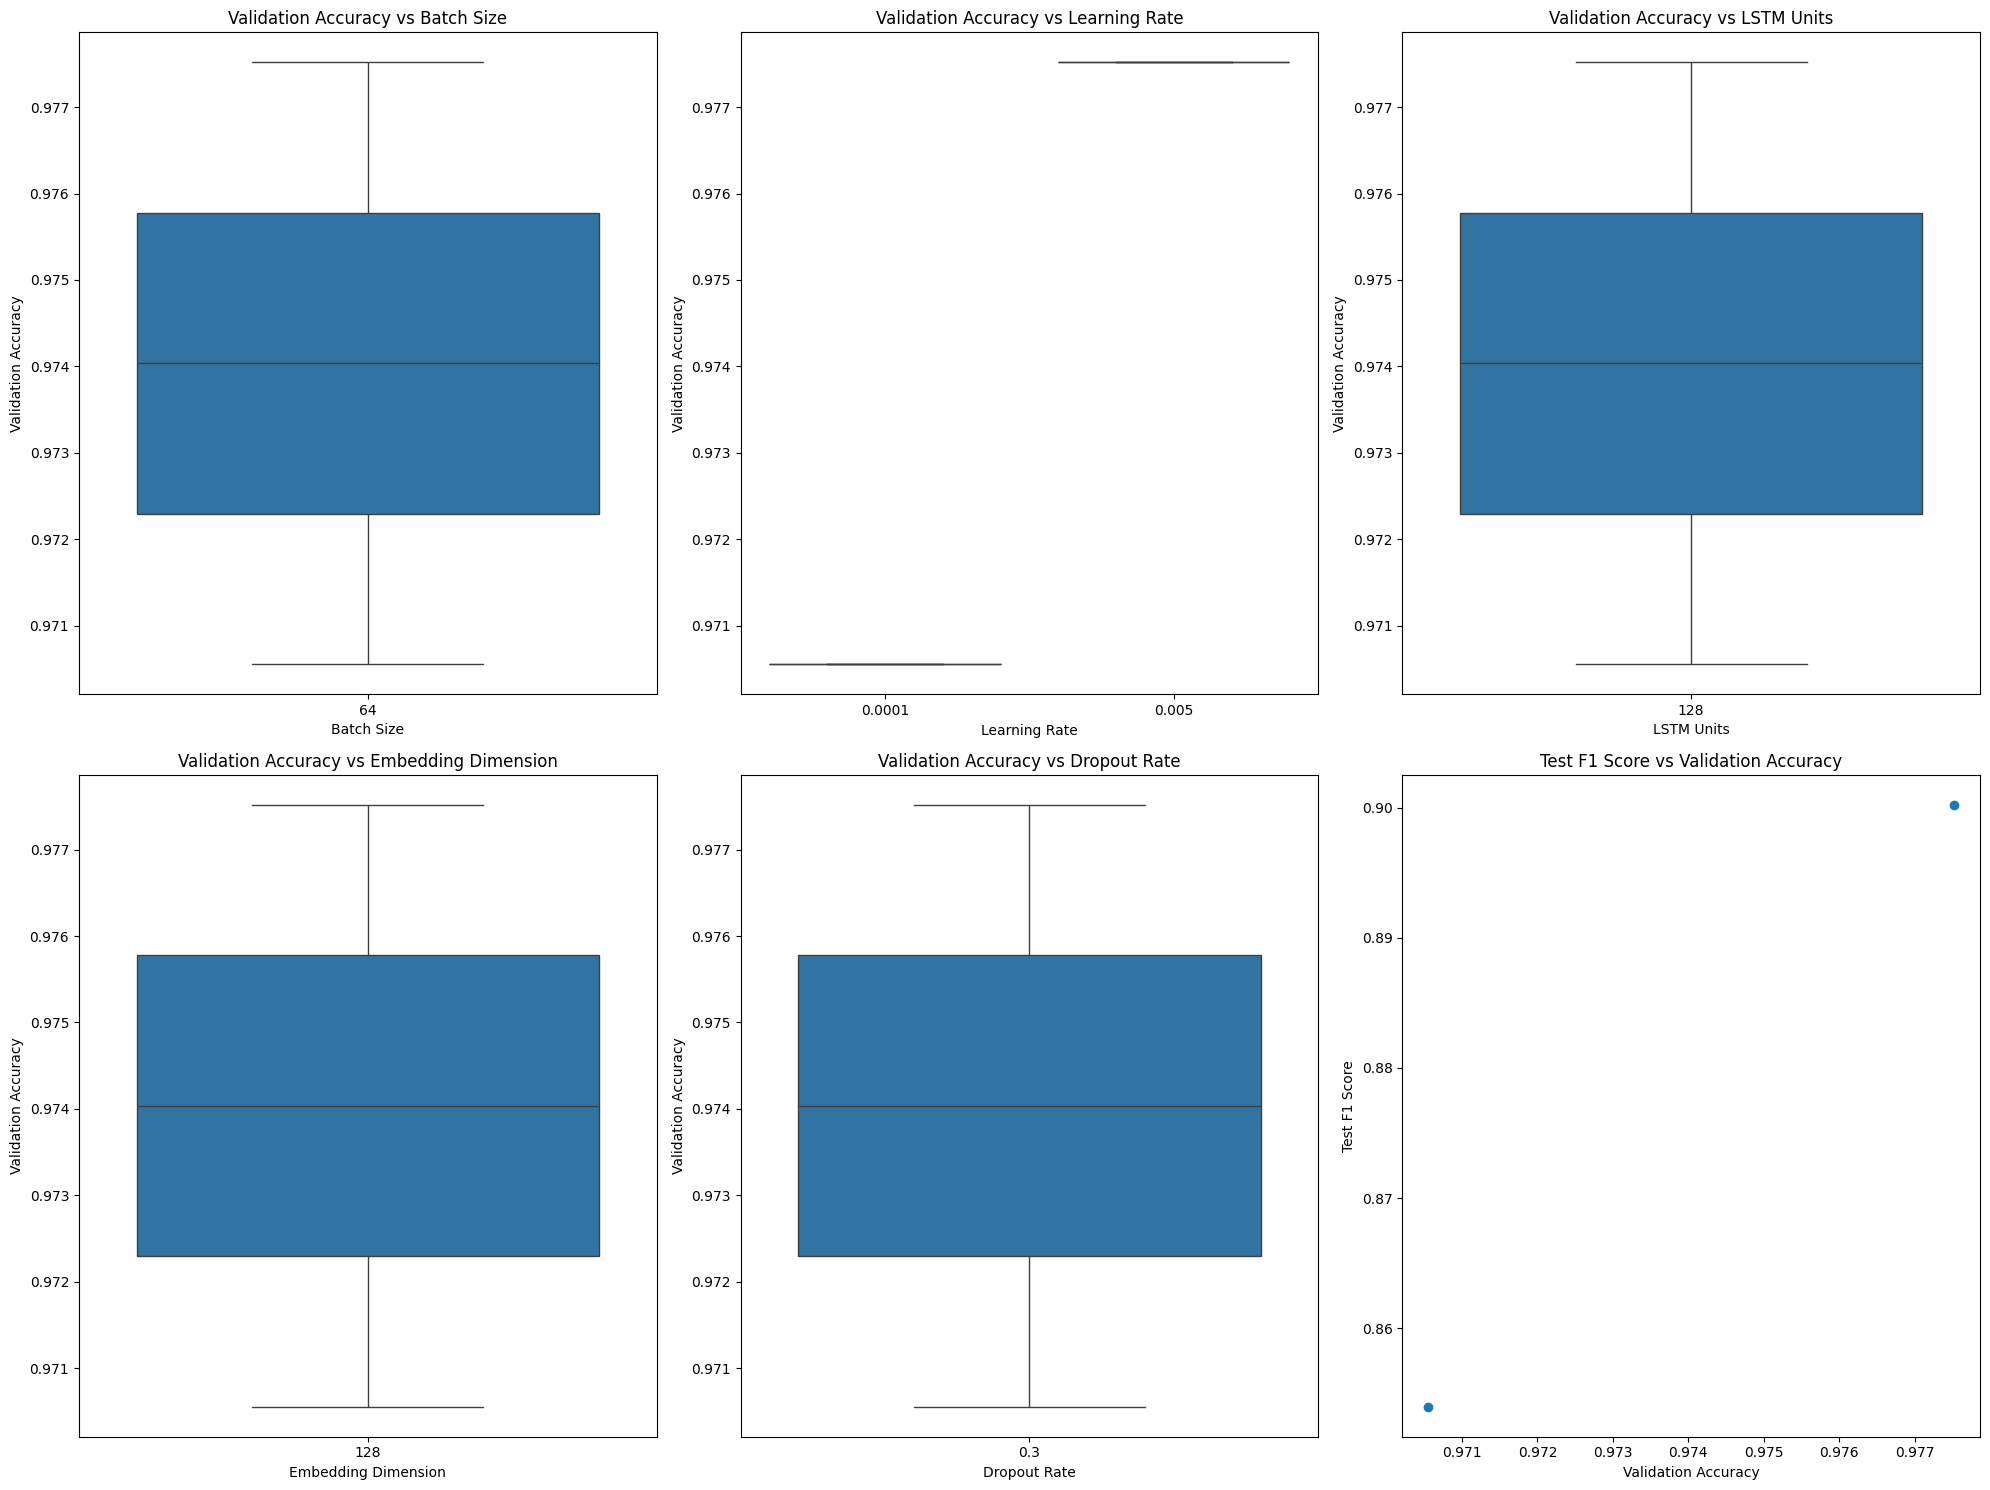

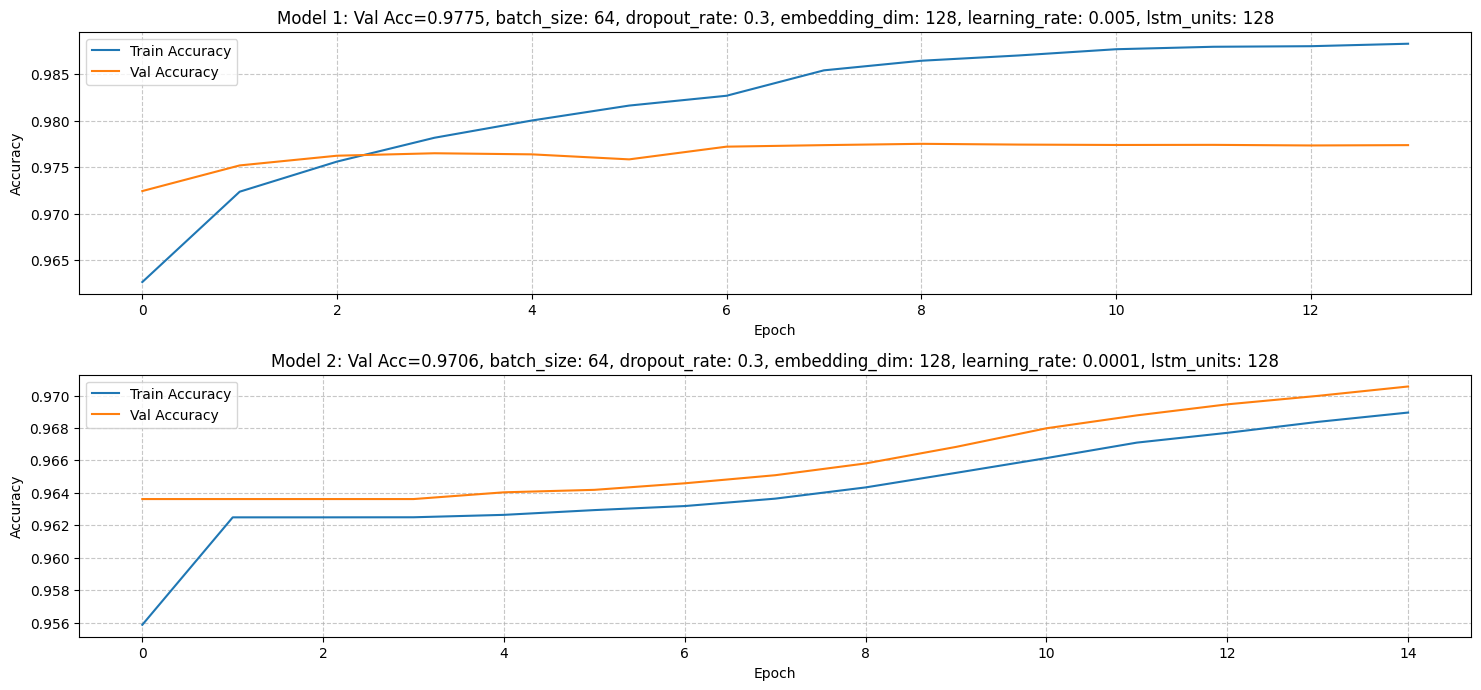

In [45]:
df = pd.DataFrame([
    {
        'batch_size': r['params']['batch_size'],
        'learning_rate': r['params']['learning_rate'],
        'lstm_units': r['params']['lstm_units'],
        'embedding_dim': r['params']['embedding_dim'],
        'dropout_rate': r['params']['dropout_rate'],
        'val_accuracy': r['best_val_accuracy'],
        'test_accuracy': r['test_accuracy'],
        'test_f1': r['test_f1'],
        'training_time': r['training_time']
    }
    for r in all_results
])


plt.figure(figsize=(20, 15))


plt.subplot(2, 3, 1)
sns.boxplot(x='batch_size', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')

plt.subplot(2, 3, 2)
sns.boxplot(x='learning_rate', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')


plt.subplot(2, 3, 3)
sns.boxplot(x='lstm_units', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs LSTM Units')
plt.xlabel('LSTM Units')
plt.ylabel('Validation Accuracy')


plt.subplot(2, 3, 4)
sns.boxplot(x='embedding_dim', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Validation Accuracy')


plt.subplot(2, 3, 5)
sns.boxplot(x='dropout_rate', y='val_accuracy', data=df)
plt.title('Validation Accuracy vs Dropout Rate')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')


plt.subplot(2, 3, 6)
plt.scatter(df['val_accuracy'], df['test_f1'])
plt.title('Test F1 Score vs Validation Accuracy')
plt.xlabel('Validation Accuracy')
plt.ylabel('Test F1 Score')

plt.tight_layout()
plt.savefig('bilstm_hyperparameter_tuning_results.png')
plt.show()

top_models = sorted(all_results, key=lambda x: x['best_val_accuracy'], reverse=True)[:3]

plt.figure(figsize=(15, 10))

for i, model in enumerate(top_models):
    plt.subplot(3, 1, i+1)
    params_str = ', '.join([f"{k}: {v}" for k, v in model['params'].items()])
    plt.plot(model['history']['accuracy'], label='Train Accuracy')
    plt.plot(model['history']['val_accuracy'], label='Val Accuracy')
    plt.title(f'Model {i+1}: Val Acc={model["best_val_accuracy"]:.4f}, {params_str}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('bilstm_top_models_learning_curves.png')
plt.show()